In [1]:
import pandas as pd
import numpy as np
from matrixprofile import *

%matplotlib inline
import matplotlib.pyplot as plt
from saxpy.sax import sax_via_window
from sklearn.preprocessing import LabelEncoder

In [2]:
import numpy as np
from saxpy.znorm import znorm
from saxpy.sax import ts_to_string
from saxpy.alphabet import cuts_for_asize

In [3]:
import seaborn as sns
import re
import gc

In [4]:
import matplotlib.patheffects as PathEffects
%matplotlib inline

from sklearn.manifold import TSNE

In [5]:
workflow = {1: 1610, 2:1934, 3:1935, 4:2360, 5:2117}

In [6]:
def get_integer_mapping(le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

In [7]:
def most_common(sax, cnt_lvl = 100, size = 5):
    #cnt =  [34, 54, 133131]
    #pattern = 'ababc'
    patterns_dict = {}
    for pattern, cnt in sax[0].items():
        if len(cnt)>cnt_lvl:
            #print(pattern+":"+(",".join([str(i) for i in cnt])))
            #print()
            patterns_dict.update({pattern:cnt})
    print("Total Number of patterns: "+str(len(patterns_dict)))
    for key,value in patterns_dict.items():
        print(key+", number of occurances: ", str(len(value)))
        print(sax[1][value[0]:value[0]+size])
        print(sax[1][value[5]:value[5]+size])
        print(sax[1][value[10]:value[10]+size])
        print(sax[1][value[1]:value[1]+size])
        print(sax[1][value[6]:value[6]+size])
        print(sax[1][value[11]:value[11]+size])
        print()

Most Common 1 gets us the Most common patterns, which occur more than cnt_lvl. O/P is a transformed list and the label list for further Clustering

In [8]:
def most_common1(sax, cnt_lvl = 100, size = 5):
    patterns_dict = {}
    for pattern, cnt in sax[0].items():
        if len(cnt)>cnt_lvl:
            #print(pattern+":"+(",".join([str(i) for i in cnt])))
            #print()
            patterns_dict.update({pattern:cnt})
    pattern1 = sax[1]
    
    lbls = []
    for i in range(0, len(pattern1)):
        if re.match('c-chigh',pattern1[i]):
                lbls.append(3)
        elif re.match('c-bmed',pattern1[i]):
                lbls.append(2)
        elif re.match('c-alow',pattern1[i]):
                lbls.append(1)
        else:
            if re.match('v',pattern1[i]):
                lbls.append(200+int(re.findall('\d+',pattern1[i])[0]))
            elif re.match('e',pattern1[i]):
                lbls.append(300+int(re.findall('\d+',pattern1[i])[0]))
            elif re.match('l',pattern1[i]):
                lbls.append(400+int(re.findall('\d+',pattern1[i])[0]))
            elif re.match('s',pattern1[i]):
                lbls.append(500+int(re.findall('\d+',pattern1[i])[0]))
            elif re.match('z',pattern1[i]):
                lbls.append(600+int(re.findall('\d+',pattern1[i])[0]))
            elif re.match('p',pattern1[i]):
                lbls.append(700+int(re.findall('\d+',pattern1[i])[0]))
            elif re.match('break',pattern1[i]):
                lbls.append(100+int(re.findall('\d+',pattern1[i])[0]))
            elif re.match('stop',pattern1[i]):
                lbls.append(800+int(re.findall('\d+',pattern1[i])[0]))
    df_list = []
    lbl_list = []
    for key,value in patterns_dict.items():
        for j in value:
            df_list.append(sax[1][j:j+5])
            lbl_list.append(lbls[j:j+5])
            print(sax[1][j:j+5])
            print()
    return df_list,lbl_list

Motif Analysis

In [9]:
def plot_motifs(mtfs, labels, ax, m, pattern):

    colori = 0
    colors = 'rgbcm'
    for ms,l in zip(mtfs,labels):
        c =colors[colori % len(colors)]
        starts = list(ms)
        ends = [min(s + m,len(pattern)-1) for s in starts]
        ax.plot(starts, pattern[starts],  c +'o',  label=l)
        ax.plot(ends, pattern[ends],  c +'o', markerfacecolor='none')
        for nn in ms:
            ax.plot(range(nn,nn+m),pattern[nn:nn+m], c , linewidth=2)
        colori += 1

    ax.plot(pattern, 'k', linewidth=1, label="data")
    ax.legend()

Get the count of classification activities, performed continuosly

In [10]:
def get_activities_cnts(df):
    df['category2'][df['category2']=='communal'] = 'z'
    df['category'] = df['category2'].apply(lambda x: x[0])
    users1 = []
    actions1 = []
    users = np.array(df.userID.tolist())
    sessions = np.array(df.session.tolist())
    for i in range(1,len(users)):
        if users[i] != users[i-1]:
            actions1.append('stop')
            users1.append(users1[-1])
        elif sessions[i] != sessions[i-1]:
            actions1.append('break')
            users1.append(users1[-1])
        actions1.append(df.category[i])
        users1.append(users[i])
    actions_new = pd.DataFrame({'userID':users1, 'actions':actions1})
    
    
    my_list = []
    for name, groups in actions_new.groupby('userID'):
        user_list = [['0',1]]
        cnt_list = 0
        category = groups.actions.tolist()
        for i in range(0,len(category)):
            if category[i] == user_list[cnt_list][0]:
                user_list[cnt_list][1]+=1
            else:
                user_list.append([category[i],1])
                cnt_list+=1
        my_list.append(user_list[1:])    
    
    for i in range(0,len(my_list)):
        my_list[i] = ["".join([str(k) for k in j]) for j in my_list[i]]
    
    flat_list1 = [item for sublist in my_list for item in sublist]
    print(flat_list1[:10])
    new_cnt = []
    print("Starting counts...")
    for i in flat_list1:
        #Change the letter to get counts for 
        if re.match('c',i):
            new_cnt.append(int(re.findall('\d+', i)[0]))
    
    print(new_cnt[:10])
    return my_list,new_cnt

In [11]:
def bins_qnt(data):
    quantile_list = [25, 50, 75]
    quantiles = [np.percentile(data, i, interpolation = 'midpoint') for i in quantile_list]
    quantiles
    return quantiles

In [12]:
def bins(data):
    Q1 = np.percentile(data, 25, interpolation = 'midpoint')
    Q3 = np.percentile(data, 75, interpolation = 'midpoint')
    lower_fence = Q1 - 1.5*(Q3-Q1)
    upper_fence = Q3 + 1.5*(Q3-Q1)
    return lower_fence,upper_fence

SAX transformation and creating counts

In [13]:
def get_patterns_bins1(df, abin, size = 5):
    df['category2'][df['category2']=='communal'] = 'z'
    df['category'] = df['category2'].apply(lambda x: x[0]) #get first letter of each activity
    users1 = []
    actions1 = []
    users = np.array(df.userID.tolist())
    sessions = np.array(df.session.tolist())
    for i in range(1,len(users)):
        if users[i] != users[i-1]:
            actions1.append('stop')
            users1.append(users1[-1])
        elif sessions[i] != sessions[i-1]:
            actions1.append('break')
            users1.append(users1[-1])
        actions1.append(df.category[i])
        users1.append(users[i])
    actions_new = pd.DataFrame({'userID':users1, 'actions':actions1})
    
    
    my_list = []
    for name, groups in actions_new.groupby('userID'):
        user_list = [['0',1]] #initialization
        cnt_list = 0
        category = groups.actions.tolist()
        for i in range(0,len(category)):
            if category[i] == user_list[cnt_list][0]:
                user_list[cnt_list][1]+=1
            else:                    
                '''
                if user_list[cnt_list][0] == 'c':
                    if user_list[cnt_list][1] >= abin[2]:
                        user_list[cnt_list][1] = '-chigh'
                    elif user_list[cnt_list][1] >= abin[0]:
                        user_list[cnt_list][1] = '-bmed'
                    else:
                        user_list[cnt_list][1] = '-alow'
                '''
                user_list.append([category[i],1])
                cnt_list+=1
       
        my_list.append(user_list[1:])
        
    for i in range(0,len(my_list)):
        my_list[i] = ["".join([str(k) for k in j]) for j in my_list[i]]

    #users = []
    #for names,groups in df.groupby('userID'):
    #    users.append(names)
    print("Start encoding....")
    for i in range(0, len(my_list)):
        for j in range(0, len(my_list[i])):
            if re.match('c',my_list[i][j]):
                if int(re.findall('\d+',my_list[i][j])[0]) >= abin[2]:
                    my_list[i][j] = re.sub('\d+','-chigh', my_list[i][j])
                elif int(re.findall('\d+',my_list[i][j])[0]) >= abin[0]:
                    my_list[i][j] = re.sub('\d+','-bmed', my_list[i][j])
                else:
                    my_list[i][j] = re.sub('\d+','-alow', my_list[i][j])
    print("Done encoding.")
    #my_list contains acitivies by each user. A list of list, where each list consists of act by 1 user
    actions = []
    for i in my_list:
        actions.append(",".join(i+['stop1', 'stop1', 'stop1', 'stop1']))
    
    #df_temp = pd.DataFrame({'userID':users, 'actions':actions})
    flat_list_df = [item for sublist in actions for item in sublist.split(",")] #Return this list: still string 
    print("Get labels...")
    
    lbls = []
    for i in range(0, len(flat_list_df)):
        if re.match('c-chigh',flat_list_df[i]):
                lbls.append(3)
        elif re.match('c-bmed',flat_list_df[i]):
                lbls.append(2)
        elif re.match('c-alow',flat_list_df[i]):
                lbls.append(1)
        else:
            if re.match('v',flat_list_df[i]):
                lbls.append(200+int(re.findall('\d+',flat_list_df[i])[0]))
            elif re.match('e',flat_list_df[i]):
                lbls.append(300+int(re.findall('\d+',flat_list_df[i])[0]))
            elif re.match('l',flat_list_df[i]):
                lbls.append(400+int(re.findall('\d+',flat_list_df[i])[0]))
            elif re.match('s',flat_list_df[i]):
                lbls.append(500+int(re.findall('\d+',flat_list_df[i])[0]))
            elif re.match('z',flat_list_df[i]):
                lbls.append(600+int(re.findall('\d+',flat_list_df[i])[0]))
            elif re.match('p',flat_list_df[i]):
                lbls.append(700+int(re.findall('\d+',flat_list_df[i])[0]))
            elif re.match('break',flat_list_df[i]):
                lbls.append(100+int(re.findall('\d+',flat_list_df[i])[0]))
            elif re.match('stop',flat_list_df[i]):
                lbls.append(800+int(re.findall('\d+',flat_list_df[i])[0]))            
    
    lbl = LabelEncoder() 
    lbl.fit(lbls)
    #actions_lbl = [lbl.transform(i.split(",")) for i in actions]
    #flat_lbls_df = [item for sublist in actions_lbl for item in sublist]
    flat_lbls_df = lbl.transform(lbls)
    print("Labels done.")
    
    print("Start SAX transformation...")
    sax_df = sax_via_window(flat_lbls_df,size,size,size,"none", 0.01)
    print("SAX transformation done.")
    return [sax_df,flat_list_df]

Matrix profile: Run on the OP of get_patterns_bins1

In [14]:
def get_exact_patterns1(sax):
    pattern1 = sax[1] # get list of activities only
    
    lbls = []
    for i in range(0, len(pattern1)):
        if re.match('c-chigh',pattern1[i]):
                lbls.append(3)
        elif re.match('c-bmed',pattern1[i]):
                lbls.append(2)
        elif re.match('c-alow',pattern1[i]):
                lbls.append(1)
        else:
            if re.match('v',pattern1[i]):
                lbls.append(200+int(re.findall('\d+',pattern1[i])[0]))
            elif re.match('e',pattern1[i]):
                lbls.append(300+int(re.findall('\d+',pattern1[i])[0]))
            elif re.match('l',pattern1[i]):
                lbls.append(400+int(re.findall('\d+',pattern1[i])[0]))
            elif re.match('s',pattern1[i]):
                lbls.append(500+int(re.findall('\d+',pattern1[i])[0]))
            elif re.match('z',pattern1[i]):
                lbls.append(600+int(re.findall('\d+',pattern1[i])[0]))
            elif re.match('p',pattern1[i]):
                lbls.append(700+int(re.findall('\d+',pattern1[i])[0]))
            elif re.match('break',pattern1[i]):
                lbls.append(100+int(re.findall('\d+',pattern1[i])[0]))
            elif re.match('stop',pattern1[i]):
                lbls.append(800+int(re.findall('\d+',pattern1[i])[0]))            
    
    lbl = LabelEncoder() 
    lbl.fit(lbls)
    pattern = lbl.transform(lbls)

    #Plot data
    #fig, ax1 = plt.subplots(figsize=(20,5))
    #ax1.plot(np.arange(len(pattern)),pattern, label="Actual Data")
    #legend = ax1.legend(loc='upper right')
    
    m = 5
    mp = matrixProfile.stomp(pattern,m)
    mtfs ,motif_d  = motifs.motifs(pattern, mp, max_motifs=20, radius = 3)
    
    '''    
    #Append np.nan to Matrix profile to enable plotting against raw data
    mp_adj = np.append(mp[0],np.zeros(m-1)+np.nan)

    #Plot the signal data
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,sharex=True,figsize=(20,10))
    ax1.plot(np.arange(len(pattern)),pattern, label="Synthetic Data")
    ax1.set_ylabel('Signal', size=22)

    #Plot the Matrix Profile
    ax2.plot(np.arange(len(mp_adj)),mp_adj, label="Matrix Profile", color='red')
    ax2.set_ylabel('Matrix Profile', size=22)

    #Plot the Motifs
    plot_motifs(mtfs, [f"{md:.3f}" for md in motif_d], ax3,m,pattern)
    ax3.set_ylabel('Motifs', size=22)
    #plt.xlim((0,100))
    plt.show()
    ''' 
    df_list = []
    lbl_list = []
    for i in mtfs:
        for j in i:
            df_list.append(sax[1][j:j+5])
            lbl_list.append(lbls[j:j+5])
            print(sax[1][j:j+5])
            print()
    return df_list,lbl_list

In [15]:
def tsne_scatter(x, clus):
    # choose a color palette with seaborn.
    #num_classes = len(np.unique(colors))
    #palette = np.array(sns.color_palette("hls", num_classes))
    df = pd.DataFrame(x)
    act = pd.DataFrame(clus[0])
    #num_classes = act.drop_duplicates().index.values
    
    df2 = (act.groupby(act.columns.tolist())
       .apply(lambda x: tuple(x.index))
       .reset_index(name='idx'))
    
    palette = np.array(sns.color_palette("hls", act.reset_index().shape[0]))
    # create a scatter plot.
    f = plt.figure(figsize=(20, 20))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(df.iloc[:,0], df.iloc[:,1], lw=0, s=40, c=palette[range(act.reset_index().shape[0])])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    #ax.axis('off')
    ax.axis('tight')

    
    
    # add the labels for each digit corresponding to the label
    '''
    def label_point(x, y, val, ax):
        a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
        for i, point in a.iterrows():
            ax.text(point['x']+.02, point['y']+.02, str(point['val']), fontsize = 20)

    label_point(df.iloc[:,0], df.iloc[:,1], pd.Series(df.index.values), plt.gca()) 
    '''
    txts = []
    for i in range(df2.shape[0]):

        # Position of each label at median of data points.
        xtext, ytext = np.median(df.iloc[list(df2.idx.values[i]),:], axis=0)
        txt = ax.text(xtext, ytext, ",".join(act.iloc[list(df2.idx.values[i]),:].values[0]), fontsize=12)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

In [16]:
all_data = pd.read_csv('./combined_activities_2.csv')
all1 = all_data[['userID','session','new.category2']]
all1['category2'] = all1['new.category2']

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Get Acitivities acounts to get counts of classification activities for a dataset

In [17]:
act_c1 = get_activities_cnts(all1[all_data.links_workflow == workflow[1]].reset_index())
act_c2 = get_activities_cnts(all1[all_data.links_workflow == workflow[2]].reset_index())
act_c3 = get_activities_cnts(all1[all_data.links_workflow == workflow[3]].reset_index())
act_c4 = get_activities_cnts(all1[all_data.links_workflow == workflow[4]].reset_index())

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['e1', 'stop1', 'l1', 'break1', 's1', 'e2', 'stop1', 'c39', 'break1', 'v1']
Starting counts...
[39, 59, 19, 42, 1, 5, 44, 29, 9, 1]
['c70', 'stop1', 'c8', 'e5', 'c177', 's2', 'e2', 'c34', 'z1', 'break1']
Starting counts...
[70, 8, 177, 34, 1, 8, 4, 9, 14, 58]
['c111', 'v1', 's1', 'e2', 'v5', 'e5', 'c1', 'stop1', 'c37', 'break1']
Starting counts...
[111, 1, 37, 448, 113, 12, 24, 14, 67, 6]
['c3', 'v1', 'c4', 'l1', 'c28', 'v1', 'c34', 'break1', 'c51', 'e1']
Starting counts...
[3, 4, 28, 34, 51, 17, 1, 4, 8, 2]


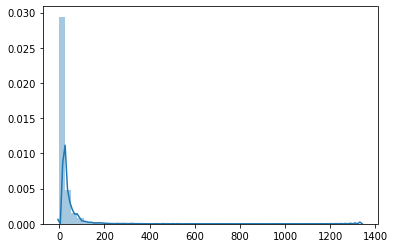

In [18]:
sns.distplot(act_c1[1])

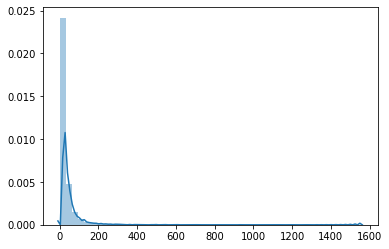

In [19]:
sns.distplot(act_c2[1])

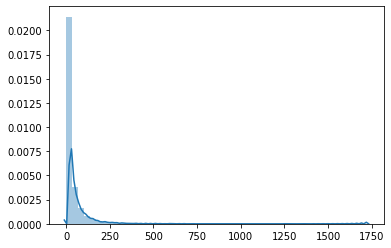

In [20]:
sns.distplot(act_c3[1])

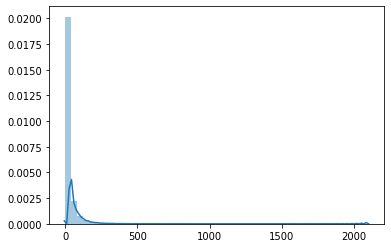

In [21]:
sns.distplot(act_c4[1])

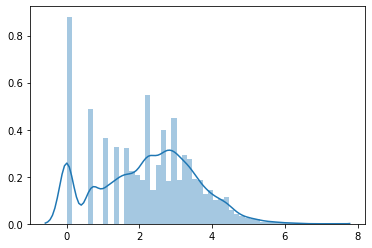

In [22]:
sns.distplot(np.log(act_c1[1]))

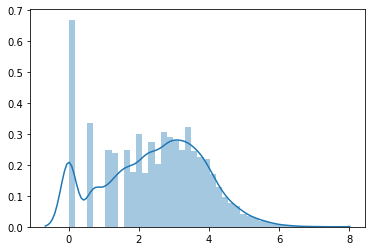

In [23]:
sns.distplot(np.log(act_c2[1]))

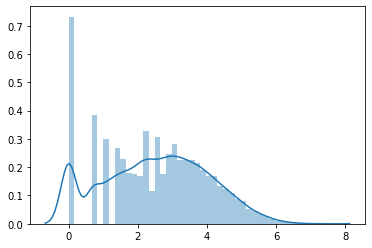

In [24]:
sns.distplot(np.log(act_c3[1]))

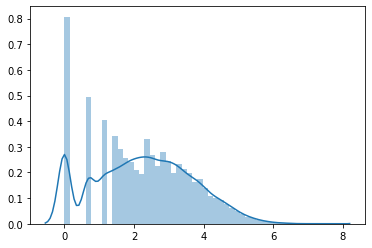

In [25]:
sns.distplot(np.log(act_c4[1]))

In [26]:
#bins1 = bins_qnt(act_c1[1])
#bins1

In [27]:
bins1 = [4.0, 10.0, 24.0]
bins2 = [4.0, 13.0, 33.0]
bins3 = [4.0, 13.0, 37.0]
bins4 = [3.0, 10.0, 26.0]
bins5 = [2.0, 6.0, 15.0]

In [28]:
super_1 = pd.read_csv('./superusers_lvl1_2.csv')
other_1 = pd.read_csv('./other_lvl1_2.csv')
s1 = super_1[['userID','session','category2']]
o1 = other_1[['userID','session','category2']]

In [29]:
super_2 = pd.read_csv('./superusers_lvl2_2.csv')
other_2 = pd.read_csv('./other_lvl2_2.csv')
s2 = super_2[['userID','session','category2']]
o2 = other_2[['userID','session','category2']]

In [30]:
super_3 = pd.read_csv('./superusers_lvl3_2.csv')
other_3 = pd.read_csv('./other_lvl3_2.csv')
s3 = super_3[['userID','session','category2']]
o3 = other_3[['userID','session','category2']]

In [31]:
super_4 = pd.read_csv('./superusers_lvl4_2.csv')
other_4 = pd.read_csv('./other_lvl4_2.csv')
s4 = super_4[['userID','session','category2']]
o4 = other_4[['userID','session','category2']]

In [32]:
s4.head()

userID  session category2
0  1057540        5  classify
1  1057540        5  classify
2  1057540        5  classify
3  1057540        5  classify
4  1057540        5  classify

In [33]:
sax_s4 = get_patterns_bins1(s4, bins4)

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mistr\Anaconda3\lib\site-packages\pandas\core\generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This

Start encoding....
Done encoding.
Get labels...
Labels done.
Start SAX transformation...
SAX transformation done.


In [34]:
most_common(sax_s4)

Total Number of patterns: 33
abebe, number of occurances:  115
['c-bmed', 'v1', 's2', 'v1', 's2']
['break1', 'v1', 'e3', 'v1', 'e1']
['v1', 'e1', 's2', 'e1', 's4']
['c-bmed', 'break1', 'e1', 'break1', 'e1']
['break1', 'e1', 's2', 'e3', 'l1']
['v1', 'e2', 's1', 'e3', 's3']

bebeb, number of occurances:  1215
['v1', 's2', 'v1', 's2', 'v3']
['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']
['v1', 's2', 'v3', 's1', 'v1']
['break1', 'e1', 'break1', 'e1', 'break1']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

dadad, number of occurances:  1404
['s2', 'v1', 's2', 'v3', 's1']
['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']
['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']
['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']
['break1', 'c-alow', 'break1', 'c-alow', 'break1']
['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

ebeba, number of occurances:  103
['s2', 'v3', 's1', 'v1', 'c-bmed']
['s4', 'e2', 's1', 'e1', 'v3']


Use most common 1 to save th epatterns from SAX for tSNE clustering

In [35]:
sax_mtf_s4 = most_common1(sax_s4,1400)

['s2', 'v1', 's2', 'v3', 's1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1',

['v1', 'c-alow', 'v1', 'c-bmed', 'v1']

['v1', 'c-bmed', 'v1', 'c-bmed', 'v1']

['v1', 'c-bmed', 'v1', 'c-bmed', 'v1']

['v1', 'c-bmed', 'v1', 'c-bmed', 'v1']

['v1', 'c-chigh', 'v1', 'c-chigh', 'v1']

['v1', 'c-bmed', 'v1', 'c-bmed', 'v1']

['v1', 'c-bmed', 'v1', 'c-bmed', 'v1']

['v1', 'c-chigh', 'v1', 'c-chigh', 'v1']

['v1', 'c-chigh', 'v1', 'c-chigh', 'v1']

['v1', 'c-chigh', 'v1', 'c-chigh', 'v1']

['v1', 'c-chigh', 'v1', 'c-chigh', 'v1']

['v1', 'c-chigh', 'v1', 'c-chigh', 'v1']

['v1', 'c-chigh', 'v1', 'c-chigh', 'v1']

['v1', 'c-chigh', 'v1', 'c-chigh', 'v1']

['v1', 'c-chigh', 'v1', 'c-chigh', 'v1']

['v1', 'c-bmed', 'v1', 'c-bmed', 'v1']

['v1', 'c-bmed', 'v1', 'c-bmed', 'v1']

['v1', 'c-bmed', 'v1', 'c-bmed', 'v1']

['v1', 'c-bmed', 'v1', 'c-bmed', 'v1']

['v1', 'c-bmed', 'v1', 'c-bmed', 'v1']

['v1', 'c-bmed', 'v1', 'c-bmed', 'v1']

['v1', 'c-chigh', 'v1', 'c-chigh', 'v1']

['v1', 'c-chigh', 'v1', 'c-chigh', 'v1']

['v1', 'c-chigh', 'v1', 'c-chigh', 'v1']

['v1', 'c-chigh'

In [36]:
sax_tsne_s4 = TSNE(random_state=22).fit_transform(pd.DataFrame(sax_mtf_s4[1]))

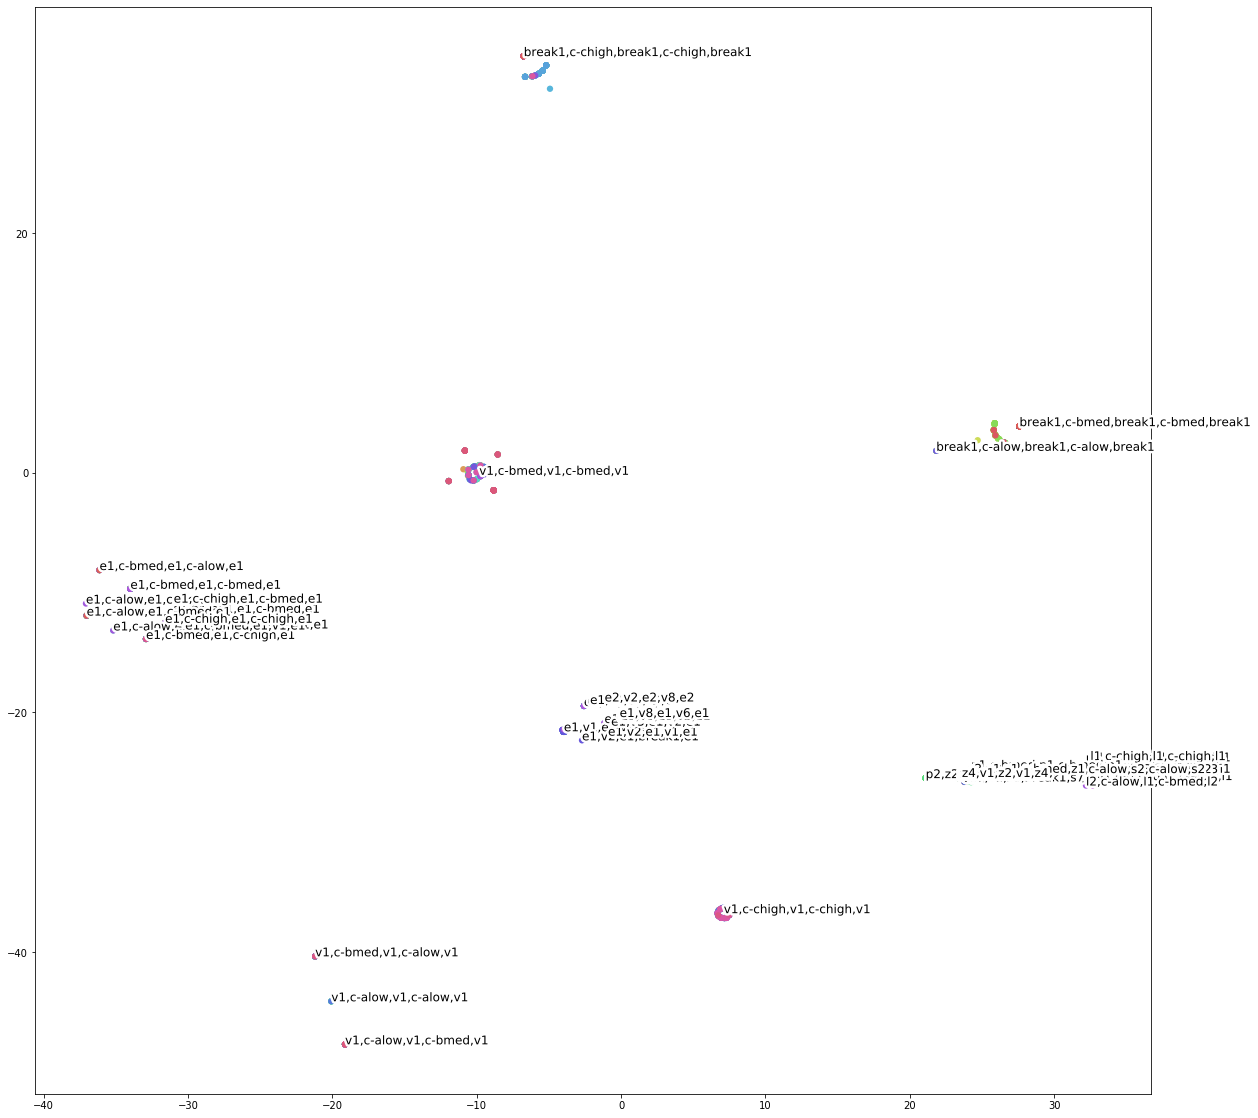

In [37]:
tsne_scatter(sax_tsne_s4, sax_mtf_s4)

In [38]:
mtf_s4 = get_exact_patterns1(sax_s4)

C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\utils.py:177: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\utils.py:200: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean[index]*mean)/(m*std[index]*std))
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\utils.py:200: RuntimeWarning: invalid value encountered in true_divide
  res = 2*m*(1-(dot-m*mean[index]*mean)/(m*std[index]*std))
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\distanceProfile.py:126: RuntimeWarning: invalid value encountered in sqrt
  distanceProfile = np.real(np.sqrt(res.astype(complex)))
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\matrixProfile.py:249: RuntimeWarning: invalid value encountered in less
  idsToUpdate = distanceProfile < mp
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\utils.py:177: RuntimeWarning: in

['s2', 'v1', 's2', 'v3', 's1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['v3', 's1', 'v1', 'c-bmed', 'v1']

['v3', 's2', 'break1', 'c-alow', 'v1']

['c-bmed', 'v1', 's1', 'c-chigh', 'v5']

['c-chigh', 'break1', 'e1', 'break1', 'v3']

['c-chigh', 'v5', 'c-bmed', 'v2', 'break1']

['c-bmed', 'v1', 'c-bmed', 'break1', 'c-chigh']

['v2', 'break1', 'v6', 'break1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['break1', 'c-chigh', 'break1', 'c-bmed', 'v1']

['v1', 'c-chigh', 'break1', 'c-alow', 'v1']

['c-bmed', 'v1', 'c-chigh', 'v1', 'c-chigh']

['c-alow', 'break1', 'c-bmed', 'break1', 'c-bmed']

['v1', 'c-chigh', 'p1', 'z2', 'v1']

['break1', 'v2', 'z1', 'p2', 'break1']

['c-alow', 'v1', 'c-alow', 'v2', 'c-alow']

['v2', 's1', 'c-bmed', 'z1', 'v1']

['v2', 'c-alow', 'v4', 'e1', 'v2']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['e1', 'v2', 's2', 'v1', 'break1']

['e2', 'v3', 's6', 'c-bmed', 'v3']

['s2', 'c-chigh', 'v1', 'c-bmed', 'v5']

['e1', 'c-bmed', 'break

In [39]:
tsne_s4 = TSNE(random_state=22).fit_transform(pd.DataFrame(mtf_s4[1]))

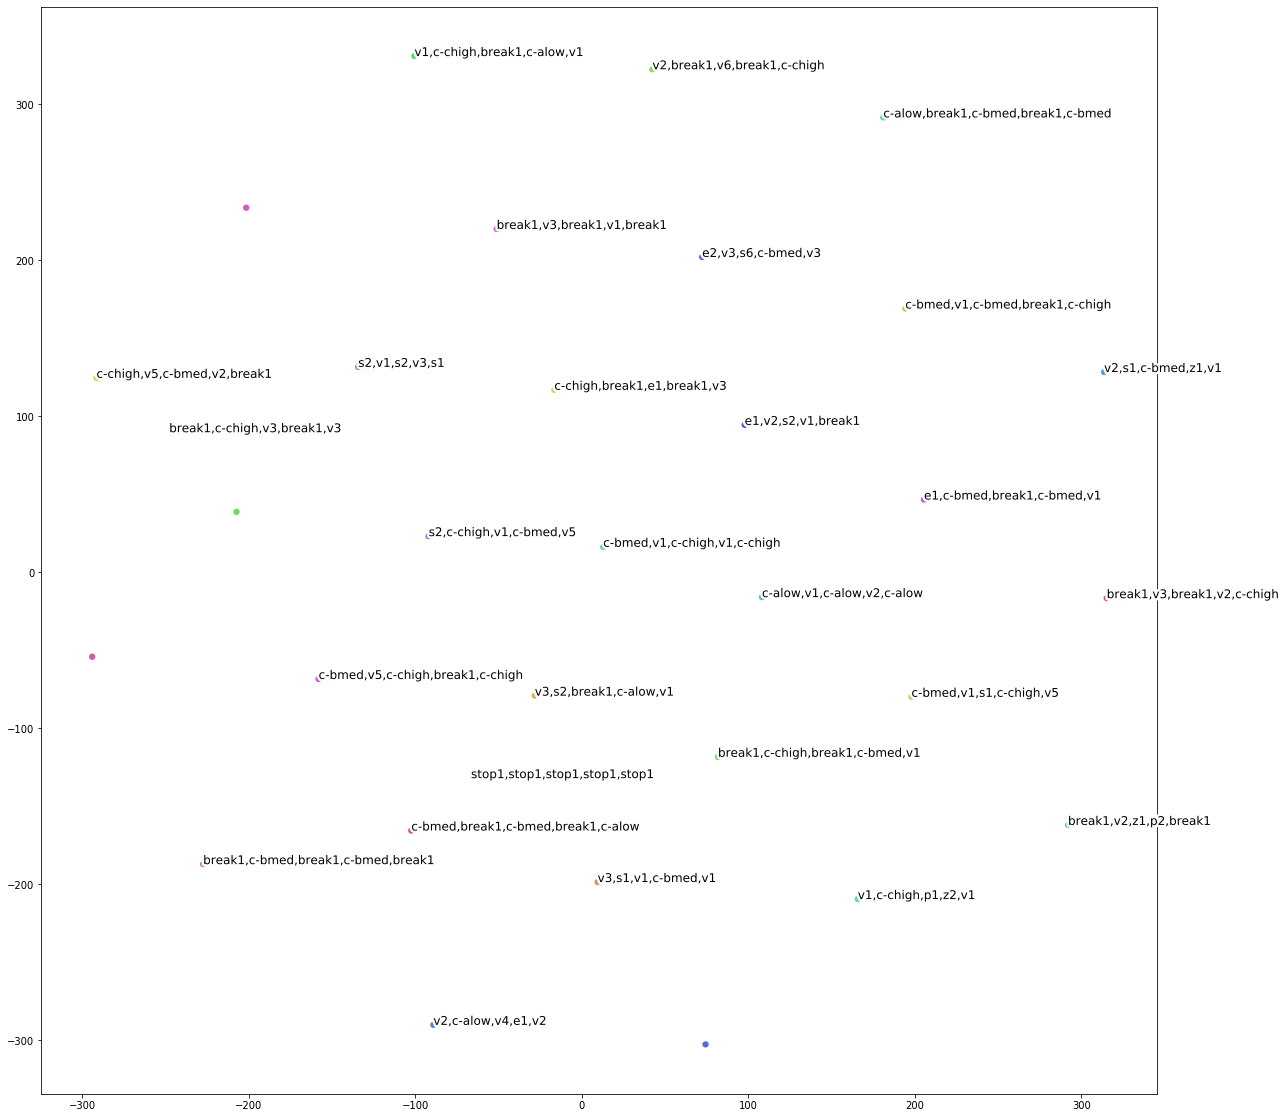

In [40]:
tsne_scatter(tsne_s4, mtf_s4)

In [41]:
sax_o4 = get_patterns_bins1(o4, bins4)

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mistr\Anaconda3\lib\site-packages\pandas\core\generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This

Start encoding....
Done encoding.
Get labels...
Labels done.
Start SAX transformation...
SAX transformation done.


In [42]:
most_common(sax_o4)

Total Number of patterns: 117
bbbeb, number of occurances:  3556
['c-bmed', 'v1', 'c-bmed', 'l1', 'c-chigh']
['v1', 'c-chigh', 'v1', 'e1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 's2', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'e1', 'c-bmed']
['c-chigh', 'v1', 'c-alow', 's2', 'c-bmed']
['c-bmed', 'v1', 'c-chigh', 'l1', 'c-alow']

bbebb, number of occurances:  2707
['v1', 'c-bmed', 'l1', 'c-chigh', 'v1']
['c-bmed', 'v1', 'l1', 'c-bmed', 'v1']
['break1', 'c-chigh', 's2', 'c-bmed', 'v1']
['break1', 'c-chigh', 'e1', 'c-bmed', 'v1']
['c-bmed', 'v1', 'e1', 'c-bmed', 'v1']
['c-chigh', 'v1', 's1', 'c-bmed', 'v1']

bebbb, number of occurances:  3776
['c-bmed', 'l1', 'c-chigh', 'v1', 'c-chigh']
['v1', 'e1', 'c-bmed', 'v1', 'c-chigh']
['v1', 's1', 'c-bmed', 'v1', 'c-bmed']
['v1', 's2', 'c-alow', 'v1', 'c-bmed']
['c-alow', 's2', 'c-bmed', 'v1', 'c-bmed']
['c-chigh', 's2', 'c-bmed', 'v1', 'c-bmed']

ebbbb, number of occurances:  3224
['l1', 'c-chigh', 'v1', 'c-chigh', 'break1']
['e1', 'c-bmed',

In [43]:
mtf_o4 = get_exact_patterns1(sax_o4)

C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\utils.py:177: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\utils.py:177: RuntimeWarning: invalid value encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\distanceProfile.py:118: RuntimeWarning: invalid value encountered in sqrt
  distanceProfile = np.real(np.sqrt(mass(query,tsB).astype(complex)))
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\matrixProfile.py:249: RuntimeWarning: invalid value encountered in less
  idsToUpdate = distanceProfile < mp
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\utils.py:200: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean[index]*mean)/(m*std[index]*std))
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\utils.py:200: RuntimeWarning: 

['c-bmed', 'v1', 'c-bmed', 'l1', 'c-chigh']

['c-bmed', 'v1', 'c-alow', 's3', 'c-bmed']

['l1', 'c-chigh', 'v1', 'c-chigh', 'break1']

['s2', 'c-bmed', 'v1', 'c-bmed', 'break1']

['c-chigh', 'break1', 'c-chigh', 'e1', 'c-bmed']

['c-bmed', 'v1', 'c-chigh', 'l1', 'c-alow']

['e1', 'c-bmed', 'v1', 's2', 'c-alow']

['e1', 'c-alow', 'v4', 'l1', 'c-alow']

['s2', 'c-alow', 'v1', 'c-bmed', 'break1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'c-alow', 'v2', 's4', 'c-bmed']

['l1', 'break1', 'c-bmed', 's2', 'c-bmed']

['s4', 'c-bmed', 's2', 'e1', 'c-bmed']

['e3', 'v2', 'e1', 'v4', 'break1']

['s3', 'c-bmed', 'break1', 'c-bmed', 'break1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['s2', 'e4', 'c-bmed', 'v1', 'l1']

['l3', 'break1', 'c-alow', 'break1', 'l1']

['v1', 'l1', 'c-bmed', 'v1', 'c-bmed']

['v1', 's1', 'c-bmed', 'v1', 'c-bmed']

['c-bmed', 'v2', 's1', 'c-alow', 'e6']

['v1', 'c-bmed', 'l1', 'c-alow', 'e2']

['v1', 'e1', 'c-bmed', 'v1', 'c-chigh']

['v1', 'e1', 'c-bme

In [44]:
tsne_o4 = TSNE(random_state=22).fit_transform(pd.DataFrame(mtf_o4[1]))

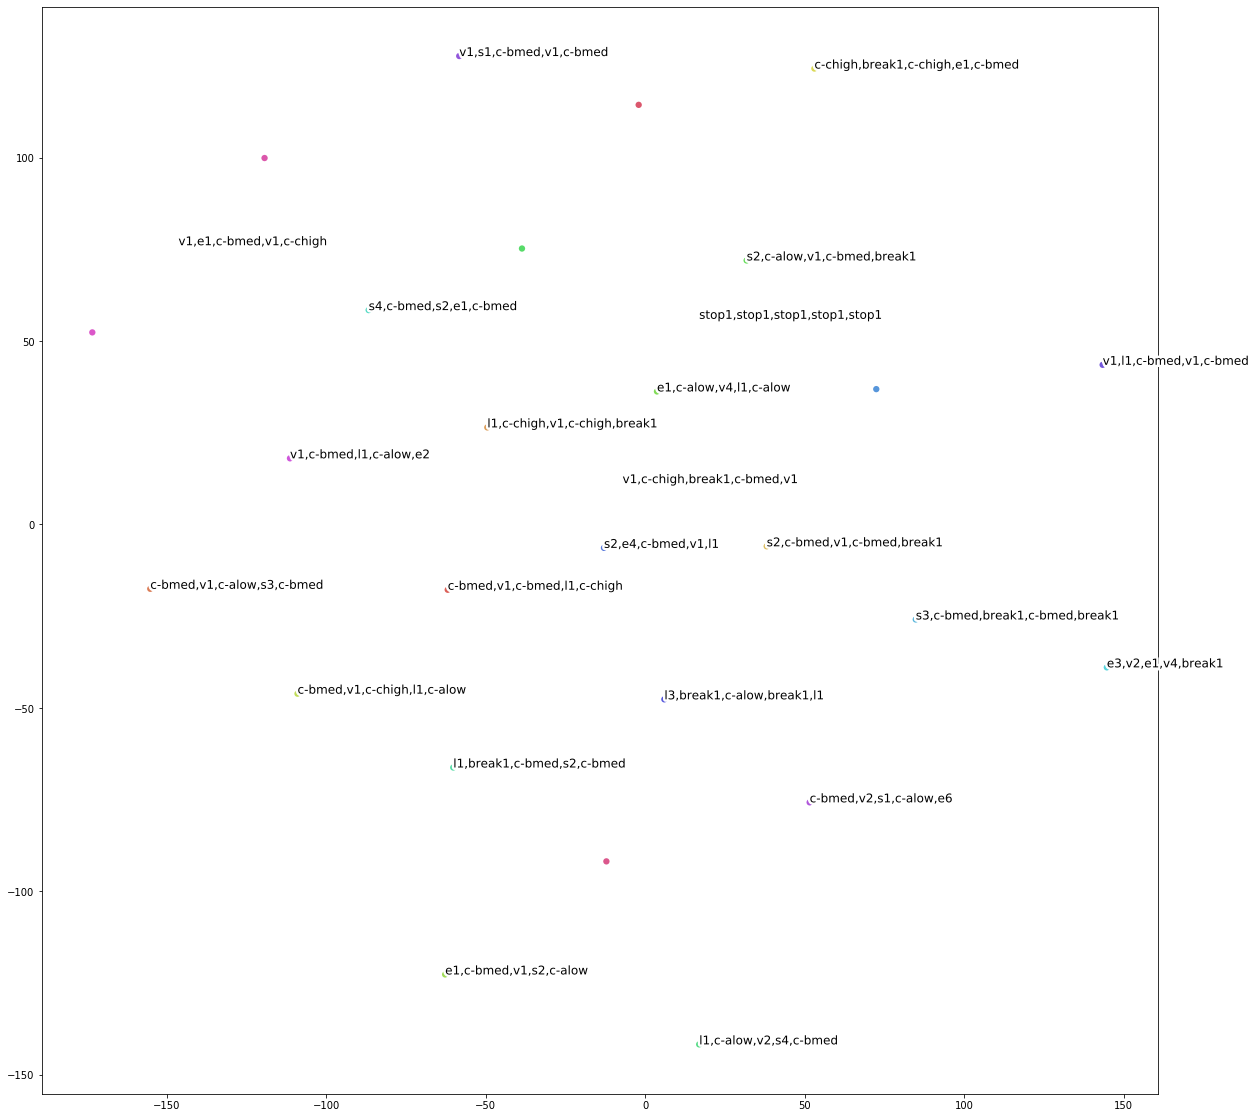

In [45]:
tsne_scatter(tsne_o4, mtf_o4)

In [46]:
gc.collect()

3785

In [47]:
sax_mtf_o4 = most_common1(sax_o4,5000)

['c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed']

['c-chigh', 'l1', 'c-alow', 'l1', 'c-alow']

['c-bmed', 'v1', 'c-bmed', 'v2', 'c-bmed']

['c-bmed', 'e1', 'c-bmed', 'e1', 'c-bmed']

['c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed']

['c-chigh', 'l1', 'c-bmed', 'l1', 'c-bmed']

['c-bmed', 'l1', 'c-alow', 'l1', 'c-bmed']

['c-alow', 'l1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l1', 'c-bmed']

['c-bmed', 'l1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l1', 'c-bmed']

['c-alow', 'l1', 'c-bmed', 'l1', 'c-alow']

['c-bmed', 'l1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['break1', 'e1', 'break1', 'e3', 'break1']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'br

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bm


['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-alow', 'l1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-bmed', 'l1', 'c-alow']

['c-bmed', 'l1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-bmed', 'l1', 'c-bmed']

['c-bmed', 'l1', 'c-bmed', 'l1', 'c-bmed']

['c-bmed', 'l1', 'c-bmed', 'l1', 'break1']

['c-alow', 'l2', 'c-bmed', 'l1', 'c-alow']

['c-bmed', 'l1', 'c-bmed', 'l1', 'c-bmed']

['break1', 'l1', 'c-bmed', 'l2', 'c-bmed']

['c-bmed', 'l1', 'c-alow', 'l1', 'c-alow']

['c-bmed', 'l1', 'c-bmed', 'l1', 'c-chigh']



['e2', 'p1', 'e1', 'z1', 'e1']

['v1', 'e2', 'v1', 'e5', 'v2']

['break1', 'v2', 'break1', 'v2', 'break1']

['break1', 'v1', 'break1', 'v1', 'break1']

['v1', 's1', 'v2', 's2', 'v2']

['v2', 's2', 'v2', 's2', 'v1']

['e1', 's2', 'e1', 's2', 'e1']

['break1', 'e1', 'break1', 'e1', 'break1']

['break1', 'e1', 'break1', 'e2', 'break1']

['c-alow', 'l1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l1', 'c-bmed']

['c-alow', 'l1', 'c-bmed', 'l1', 'c-alow']

['c-bmed', 'l1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l1', 'c-alow']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-bmed', 'l2', 'c-alow',


['c-alow', 'l1', 'c-alow', 'l2', 'c-alow']

['c-alow', 'l2', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l1', 'c-bmed']

['c-alow', 'l1', 'c-bmed', 'l1', 'c-alow']

['c-bmed', 'l1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l2', 'c-alow']

['c-alow', 'l2', 'c-alow', 'l4', 'c-bmed']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'l1', 'c-bmed', 'l1', 'c-chigh']

['c-bmed', 'l1', 'c-chigh', 'l1', 'c-bmed']

['c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed']

['c-bmed', 'e1', 'c-bmed', 'e1', 'c-bmed']

['c-bmed', 'e1', 'c-bmed', 'e1', 'c-bme


['c-alow', 'l1', 'c-bmed', 'l1', 'c-bmed']

['c-bmed', 'l1', 'c-alow', 'l1', 'c-alow']

['c-bmed', 'l1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l1', 'c-bmed']

['break1', 'l2', 'c-bmed', 'l1', 'c-bmed']

['c-alow', 'l1', 'c-alow', 'l1', 'c-bmed']

['c-alow', 'l1', 'c-bmed', 'l2', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'l1', 'c-bmed', 'l1', 'c-bmed']

['c-bmed', 'l1', 'c-bmed', 'l1', 'c-alow']

['break1', 'l1', 'c-bmed', 'l1', 'c-bmed']

['c-bmed', 'l1', 'c-bmed', 'l1', 'c-bmed']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-bmed', 'e1', 'c-bmed', 'e1', 'c-bmed']

['c-bmed', 'e1', 'c-bmed', 'e1', 'c-bmed']

['c-bmed', 'e1', 'c-bmed', 'e1', 'c-bmed']

['c-bmed', 'e4', 'c-alow', 'e3', 'c-alow']

['c-alow', 'e3', 'c-alow', 'e3', 'c-alow']

['c-alow', 'e3', 'c-alow', 'e1', 'c-bmed']

['c-bmed', 'e1', 'c-bmed', 'e1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'l1', 'c-bmed', 'l1', 'c-chigh']

['c

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-bmed', 'l1', 'c-bmed', 'l1', 'c-bmed']

['c-bmed', 'l1', 'c-bmed', 'l1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'e1', 'c-bmed', 'e1', 'c-bmed']

['c-alow', 'l4', 'c-bmed', 'l1', 'c-alow']

['c-bmed', 'l1', 'c-alow', 'l1', 'c-alow']

['break1', 'l1', 'c-bmed', 'l1', 'c-bmed']

['c-bmed', 'l1', 'c-alow', 'l1', 'c-bmed']

['c-bmed', 'e1', 'c-bmed', 'e1', 'c-bmed']

['c-bmed', 'e1', 'c-bmed', 'e1', 'c-bmed']

['c-bmed', 'e1', 'c-bmed', 'e1', 'c-bmed']

['c-alow', 'l1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l2', 'c-alow']

['c-alow', 'l2', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l1', 'c-alow']

['c-bmed', 'l1', 'c-bmed', 'l1', 'c-bmed']

['c-bmed', 'l1', 'c-bmed', 'l1', 'c

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh'

['c-bmed', 'e1', 'c-bmed', 'e1', 'c-bmed']

['c-bmed', 'e1', 'c-bmed', 'e1', 'c-bmed']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-alow', 'l1', 'c-alow', 'l2', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e2', 'c-bmed']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-bmed', 'e1', 'c-bmed', 'e2', 'c-bmed']

['c-bmed', 'e2', 'c-bmed', 'e1', 'c-bmed']

['c-bmed', 'e1', 'c-bmed', 'e1', 'c-bmed']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed']

['c-bmed', 'v1', 'c-bmed', 'v2', 'c-bmed']

['c-bmed', 'l2', 'c-alow', 'l1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed


['c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed']

['c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed']

['c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed']

['break1', 's1', 'break1', 's2', 'break1']

['c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed']

['c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed']

['c-bmed', 's3', 'break1', 's1', 'c-bmed']

['c-alow', 'l1', 'c-bmed', 'l1', 'c-bmed']

['c-alow', 'l1', 'c-bmed', 'l2', 'c-bmed']

['c-bmed', 'l2', 'c-bmed', 'l1', 'c-bmed']

['c-bmed', 'l1', 'c-bmed', 'l1', 'c-bmed']

['c-bmed', 'l1', 'c-alow', 'l1', 'c-bmed']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'l1', 'c-bmed', 'l2', 'c-chigh']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-alow', 'e2', 'c-alow', 'e1', 'c-alow']

['c-alow', 'l1', 'c-bmed', 'l1', 'c-bmed']

['c-bmed', 'l1', 'c-bmed', 'l1', 'c-alow']

['c-bmed', 'l1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l1', 'c-alow']

['

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['br


['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-chigh', 'e1']

['e1', 'c-chigh', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-chigh', 'e1']

['e1', 'c-chigh', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-chigh', 'e1']

['e1', 'c-chigh', 'e1', 'c-alow', 'e1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['e1', 'c-alow', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-bmed', 'e1']

['e1', 'c-alow', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['e1', 'c-alow', 'e1', 'c-bmed', 'e1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['l1', 'c-alow', 'l1', 'c-alow', 'l2']

['l1', 'c-alow', 'l2', 'c-alow', 'l1']

['l2', 'c-alow',


['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['l1', 'c-chigh', 'l1', 'c-chigh', 'l1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['s


['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-chigh', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['l1', 'c-bmed', 'l1', 'c-chigh', 'l1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['z1', 'e2', 'z2', 'e1', 'z1']

['z1', 'e1', 'z1', 'v1', 'z1']

['z2', 'v1', 'z2', 'v1', 'z1']

['z2', 'v1', 'z1', 'v1', 'z1']

['z1', 'e3', 'z1', 'v1', 'z1']

['z1', 'v1', 'z1', 'e1', 'z1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bme


['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 


['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['e1', 'c-alow', 'e1', 'v1', 'e1']

['e1', 'c-chigh', 'e1', 'c-chigh', 'e1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['v1', 'break1', 'v1', 'break1', 'v1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['v1', 'break1', 'v1', 'bre

['e1', 'c-alow', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-alow', 'e1']



['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['l1', 'c-chigh', 'l1', 'c-bmed', 'l1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break

['l2', 'c-alow', 'l1', 'c-bmed', 'l2']

['l1', 'c-bmed', 'l1', 'c-alow', 'l2']

['l1', 'c-alow', 'l2', 'c-alow', 'l1']

['l2', 'c-alow', 'l1', 'c-bmed', 'l1']

['l1', 'c-bmed', 'l1', 'c-bmed', 'l1']

['l1', 'c-bmed', 'l1', 'c-bmed', 'l1']

['l1', 'c-bmed', 'l1', 'c-chigh', 'l1']

['l1', 'c-chigh', 'l1', 'c-bmed', 'l1']

['l1', 'c-bmed', 'l1', 'c-chigh', 'l1']

['v1', 'c-bmed', 'v1', 'c-bmed', 'v1']

['v1', 'c-bmed', 'v1', 'c-bmed', 'v1']

['l1', 'c-bmed', 'l1', 'c-alow', 'l1']

['l1', 'c-alow', 'l1', 'c-bmed', 'l1']

['l1', 'c-bmed', 'l1', 'c-bmed', 'l1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['l2', 'c-bmed', 'l1', 'c-alow', 'l2']

['l1', 'c-alow', 'l2', 'c-bmed', 'l1']

['l1', 'c-bmed', 'l1', 'c-bmed', 'l1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['l1', 'c-alow', 'l1', 'c-alow', 'l1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['break1', 'c

In [48]:
sax_tsne_o4 = TSNE(random_state=22).fit_transform(pd.DataFrame(sax_mtf_o4[1]))

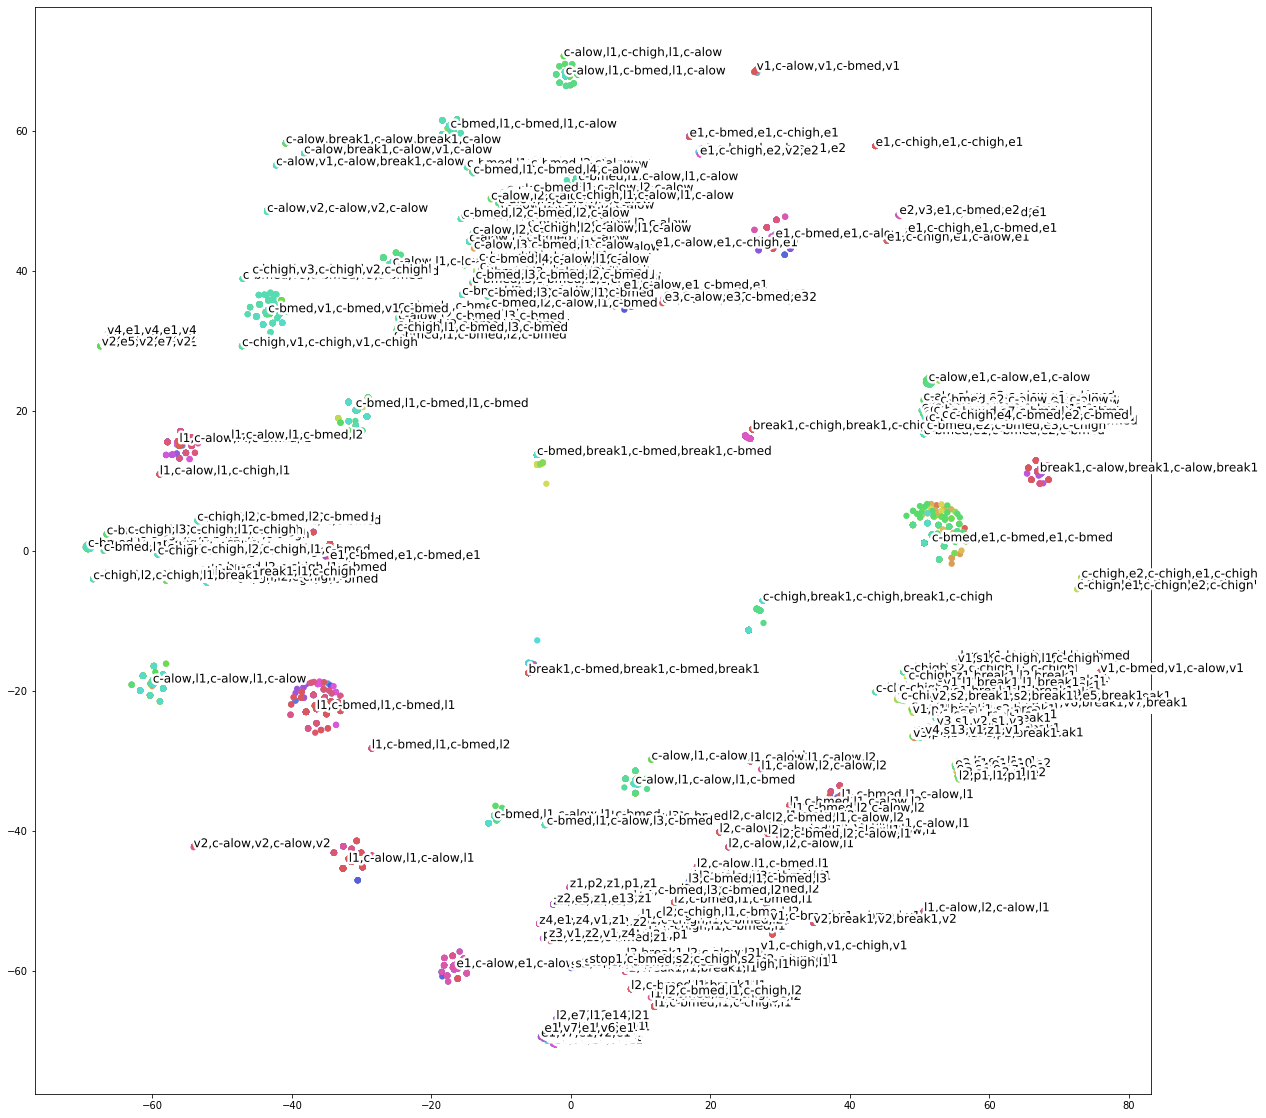

In [49]:
tsne_scatter(sax_tsne_o4, sax_mtf_o4)

In [50]:
sax_s3 = get_patterns_bins1(s3, bins3)

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mistr\Anaconda3\lib\site-packages\pandas\core\generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This

Start encoding....
Done encoding.
Get labels...
Labels done.
Start SAX transformation...
SAX transformation done.


In [51]:
most_common(sax_s3)

Total Number of patterns: 0


In [55]:
sax_mtf_s3 = most_common1(sax_s3, 20)

['c-chigh', 'v1', 'c-bmed', 'v1', 'c-chigh']

['e12', 'p1', 'e5', 'p1', 'e13']

['e11', 'p1', 'e1', 'p1', 'e8']

['v2', 's1', 'v1', 's4', 'v3']

['e2', 'z1', 'v1', 'z4', 'e2']

['e4', 'z1', 'e2', 'z1', 'e4']

['e3', 'z1', 'e1', 'z2', 'e2']

['c-bmed', 'e1', 'c-alow', 'e1', 'c-bmed']

['c-bmed', 'l1', 'c-alow', 'l2', 'c-bmed']

['c-bmed', 'l1', 'c-alow', 'l2', 'c-bmed']

['v5', 's1', 'v2', 's1', 'v4']

['break1', 'l1', 'c-alow', 'l1', 'c-bmed']

['c-chigh', 'v1', 'c-bmed', 'v1', 'c-chigh']

['v1', 'l1', 'c-bmed', 'z1', 'v1']

['c-chigh', 'break1', 'c-bmed', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-bmed', 'break1', 'c-chigh']

['c-chigh', 'break1', 'c-bmed', 'break1', 'c-chigh']

['c-chigh', 'l2', 'c-bmed', 'l1', 'c-chigh']

['c-chigh', 'v1', 'c-bmed', 'v1', 'c-chigh']

['c-bmed', 'l1', 'c-alow', 'l3', 'c-bmed']

['c-bmed', 'e1', 'c-alow', 'e1', 'c-bmed']

['c-bmed', 'e1', 'c-alow', 'e1', 'c-bmed']

['c-bmed', 'e1', 'c-alow', 'e1', 'c-bmed']

['c-bmed', 'l1', 'c-alow', 'l1', 'c-chi

In [56]:
sax_tsne_s3 = TSNE(random_state=22).fit_transform(pd.DataFrame(sax_mtf_s3[1]))

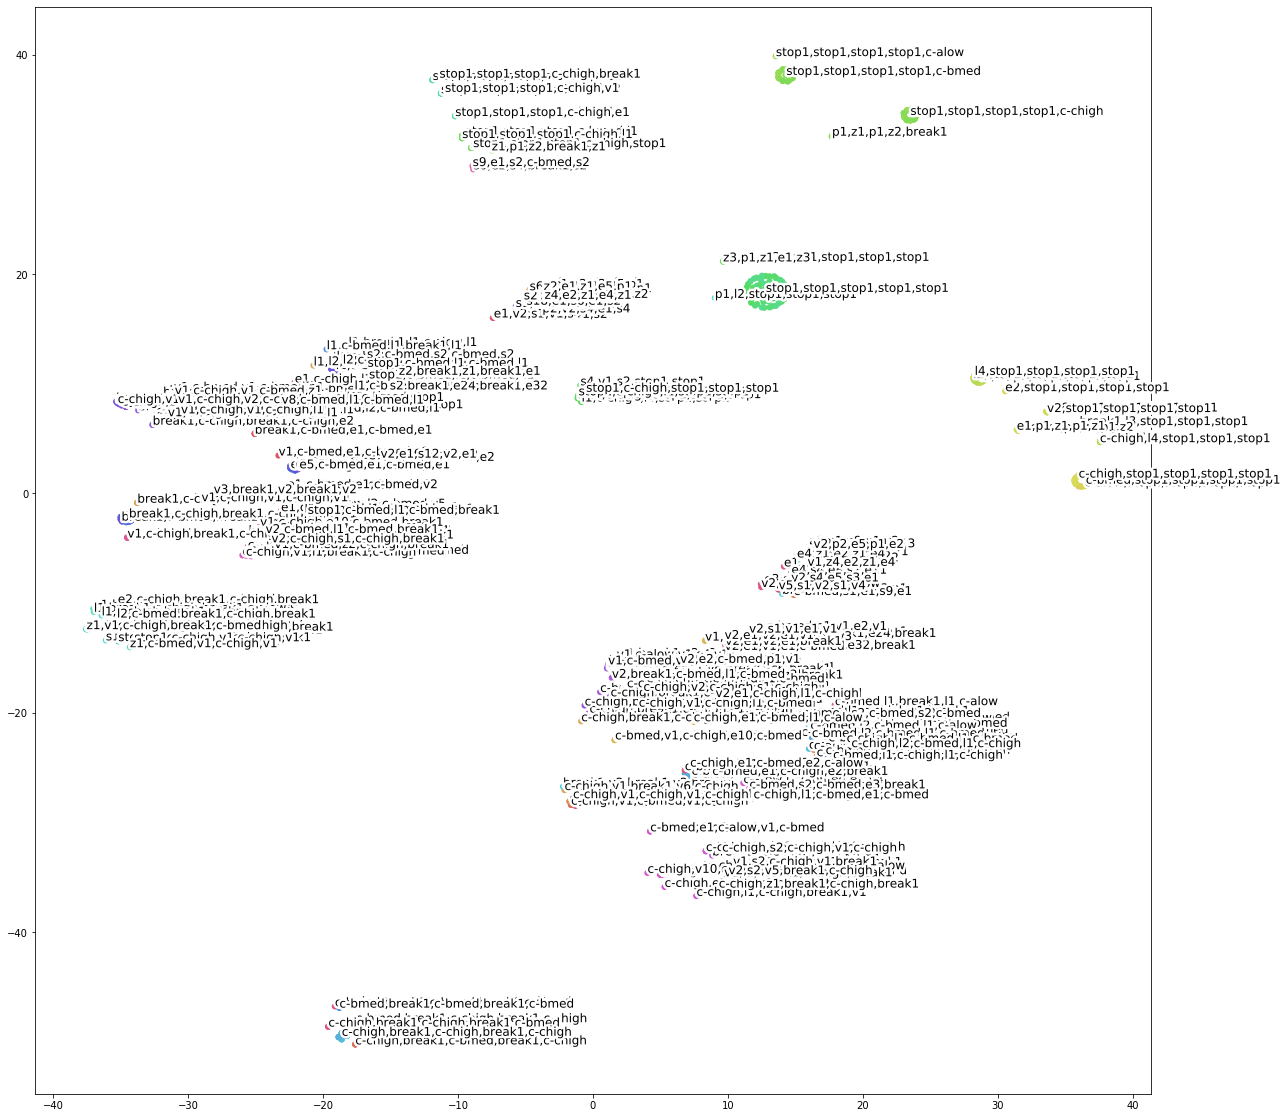

In [57]:
tsne_scatter(sax_tsne_s3, sax_mtf_s3)

In [58]:
mtf_s3 = get_exact_patterns1(sax_s3)

C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\utils.py:177: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\utils.py:177: RuntimeWarning: invalid value encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\distanceProfile.py:118: RuntimeWarning: invalid value encountered in sqrt
  distanceProfile = np.real(np.sqrt(mass(query,tsB).astype(complex)))
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\matrixProfile.py:249: RuntimeWarning: invalid value encountered in less
  idsToUpdate = distanceProfile < mp
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\utils.py:200: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean[index]*mean)/(m*std[index]*std))
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\utils.py:200: RuntimeWarning: 

['c-chigh', 'v1', 'c-bmed', 'v1', 'c-chigh']

['break1', 'v1', 'c-bmed', 'v1', 'c-chigh']

['v1', 'c-chigh', 'break1', 'v5', 'c-bmed']

['c-chigh', 'v1', 'break1', 'v6', 'c-chigh']

['v6', 'c-chigh', 'stop1', 'stop1', 'stop1']

['stop1', 'c-bmed', 'stop1', 'stop1', 'stop1']



C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\distanceProfile.py:66: RuntimeWarning: invalid value encountered in sqrt
  distanceProfile = np.real(np.sqrt(mass(query,tsB).astype(complex)))


In [59]:
tsne_s3 = TSNE(random_state=22).fit_transform(pd.DataFrame(mtf_s3[1]))

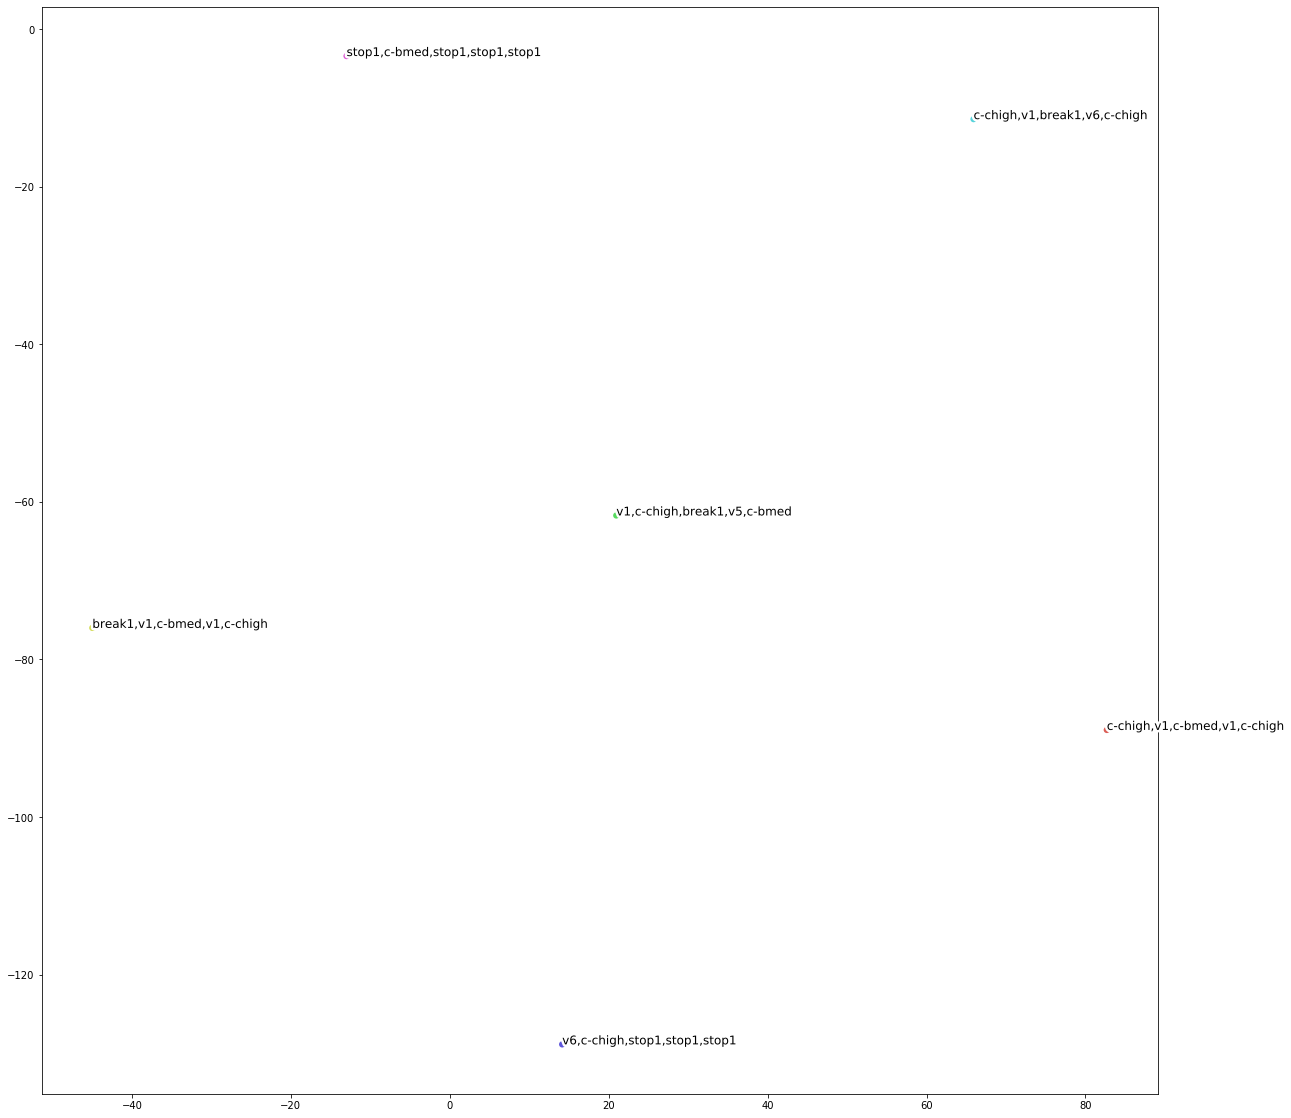

In [60]:
tsne_scatter(tsne_s3, mtf_s3)

1499915  624019       6 1602403  737501 1303502  336603 1525482  793276 1525165 1455658 1509927 1438974 1460871 1378001  796717 1520672  386563  309605 1495579     873  408711 1496976


In [61]:
sax_o3 = get_patterns_bins1(o3, bins3)

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mistr\Anaconda3\lib\site-packages\pandas\core\generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This

Start encoding....
Done encoding.
Get labels...
Labels done.
Start SAX transformation...
SAX transformation done.


In [62]:
most_common(sax_o3)

Total Number of patterns: 86
acaee, number of occurances:  174
['v5', 'e5', 'c-alow', 'stop1', 'stop1']
['c-bmed', 'e2', 'c-alow', 'stop1', 'stop1']
['v1', 'e1', 'c-bmed', 'stop1', 'stop1']
['c-chigh', 'e2', 'c-chigh', 'stop1', 'stop1']
['c-bmed', 'e1', 'c-bmed', 'stop1', 'stop1']
['c-bmed', 'e1', 'c-chigh', 'stop1', 'stop1']

baddd, number of occurances:  121
['e5', 'c-alow', 'stop1', 'stop1', 'stop1']
['e1', 'c-bmed', 'stop1', 'stop1', 'stop1']
['e1', 'c-alow', 'stop1', 'stop1', 'stop1']
['e2', 'c-chigh', 'stop1', 'stop1', 'stop1']
['e2', 'c-chigh', 'stop1', 'stop1', 'stop1']
['e1', 'c-bmed', 'stop1', 'stop1', 'stop1']

adddd, number of occurances:  2802
['c-alow', 'stop1', 'stop1', 'stop1', 'stop1']
['c-chigh', 'stop1', 'stop1', 'stop1', 'stop1']
['l1', 'stop1', 'stop1', 'stop1', 'stop1']
['l1', 'stop1', 'stop1', 'stop1', 'stop1']
['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']
['l1', 'stop1', 'stop1', 'stop1', 'stop1']

eeeee, number of occurances:  2855
['stop1', 'stop1', 'stop1', 

In [81]:
sax_mtf_o3 = most_common1(sax_o3,1500)

['c-alow', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['c-chigh', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['c-chigh', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['c-chigh', 'stop1', 'stop1', 'stop1', 'stop1']

['l3', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['c-chigh', 'stop1', 'stop1', 'stop1', 'stop1']

['c-alow', 'stop1', 'stop1', 'stop1', 'stop1']

['c-chigh', 'stop1', 'stop1', 'stop1', 'stop1']

['c-alow', 'l3', 'stop1', 'stop1', 'stop1']

['l3', 'stop1', 'stop1', 'stop1', 'stop1']

['v1', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 's

['c-chigh', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['l2', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['c-chigh', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['c-alow', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['c-alow', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['l2', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['c-chigh', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'st

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['e2', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['c-alow', 'stop1', 'stop1', 'stop1', 'stop1']

['c-chigh', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['v1', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['c-chigh', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['l3', 'stop1', 'stop1', 'stop1', 'stop1']

['l3', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['l2', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['v1', 'stop1', 'stop1', 'stop1', 'stop1']

['e1', 'stop1', 'stop1', 'stop1', 'stop1']

['l1',


['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 's

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'st

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'st


['stop1', 'stop1', 'stop1', 'stop1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'c-alow']

['stop1', 'stop1', 'stop1', 'stop1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'c-alow']

['stop1', 'stop1', 'stop1', 'stop1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'st

['stop1', 'stop1', 'stop1', 'stop1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'c-alow']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-alow']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'c-alow']

['stop1', 'stop1', 'stop1', 'stop1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'c-alow']

['stop1', 'stop1', 'stop1', 'stop1', 'c-alow']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'sto


['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-alow']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'c-chigh']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop


['stop1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['stop1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['stop1', 'c-bmed', 'v1', 'break1', 'c-bmed']

['l1', 'c-chigh', 'v1', 'c-chigh', 'v1']

['e1', 'c-alow', 'v1', 'c-bmed', 'v1']

['e1', 'c-alow', 'v1', 'c-alow', 'v1']

['s2', 'c-bmed', 'v1', 'c-bmed', 'v1']

['stop1', 'c-chigh', 'v1', 'c-bmed', 'break1']

['stop1', 'c-chigh', 'v1', 'c-bmed', 'v1']

['z3', 'v3', 'c-chigh', 'v3', 'c-chigh']

['stop1', 'c-chigh', 'v1', 'c-bmed', 'v1']

['s2', 'c-bmed', 'v1', 'c-bmed', 'v1']

['l1', 'c-bmed', 'break1', 'c-bmed', 'v1']

['p1', 'stop1', 'stop1', 'stop1', 'stop1']

['e1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['stop1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['z1', 'stop1', 'stop1', 'stop1', 'stop1']

['stop1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['stop1', 'c-bmed', 'break1', 'c-chigh', 'break1']

['l1', 'c-bmed', 'break1', 'c-alow', 'v2']

['stop1', 'c-bmed', 'v1', 'c-chigh', 'v1']

['l1', 'c-bmed', 'break1', 'c-alow', 'v1


['c-bmed', 'break1', 'c-bmed', 'e1', 'c-bmed']

['c-alow', 'v1', 'c-bmed', 'l1', 'c-bmed']

['c-bmed', 'v1', 'break1', 'e3', 'c-bmed']

['c-alow', 'break1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'break1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'v1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'v1', 'c-alow', 'l5', 'c-alow']

['v1', 'c-alow', 'v1', 'l1', 'v1']

['break1', 'c-alow', 'v1', 'l2', 'c-alow']

['c-alow', 'break1', 'v1', 'l1', 'v1']

['c-alow', 'break1', 'v2', 'e1', 'v1']

['c-alow', 'v1', 'c-alow', 'l1', 'c-alow']

['c-alow', 'v1', 'break1', 'l2', 'break1']

['c-alow', 'break1', 'v2', 'z4', 'v1']

['c-bmed', 'v1', 'c-alow', 'l1', 'c-alow']

['v1', 'break1', 'c-bmed', 'l1', 'c-alow']

['c-alow', 'v1', 'c-bmed', 'l1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'l1', 'c-alow']

['v1', 'c-bmed', 'v1', 'l1', 'c-alow']

['v1', 'break1', 'c-alow', 'l1', 'c-bmed']

['c-bmed', 'v1', 'c-alow', 'l1', 'c-alow']

['v1', 'c-bmed', 'v1', 'l1', 'c-alow']

['v2', 'c-alow', 'break1', 'l1', 'v2']

['c


['c-bmed', 'v1', 'c-alow', 'l1', 'c-alow']

['c-bmed', 'break1', 'c-bmed', 'l1', 'c-alow']

['break1', 'v1', 'c-bmed', 'l1', 'c-bmed']

['break1', 'v1', 'c-alow', 'l1', 'c-bmed']

['c-alow', 'v1', 'c-alow', 'l1', 'c-bmed']

['c-bmed', 'v1', 'c-chigh', 'l1', 'c-alow']

['c-bmed', 'v1', 'c-alow', 'l1', 'c-chigh']

['c-chigh', 'break1', 'c-bmed', 'l1', 'c-alow']

['c-alow', 'break1', 'c-bmed', 'e1', 'c-alow']

['c-alow', 'v1', 'c-bmed', 'l1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'e1', 'c-alow']

['v1', 'c-bmed', 'v1', 'e2', 'c-alow']

['c-bmed', 'v1', 'c-bmed', 's1', 'c-bmed']

['c-alow', 'break1', 'c-bmed', 'l1', 'c-alow']

['c-bmed', 'break1', 'c-chigh', 'e1', 'c-bmed']

['c-chigh', 'v3', 'c-bmed', 'l1', 'c-chigh']

['c-bmed', 'break1', 'c-chigh', 'l2', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'l1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'l1', 'c-bmed']

['c-bmed', 'break1', 'c-chigh', 'v10', 'c-chigh']

['c-bmed', 'break1', 'c-bmed', 'l1', 'c-bmed']

['c-alow', 'v1', 'c-bmed'


['c-chigh', 'e2', 'c-bmed', 'break1', 'c-alow']

['c-bmed', 'e1', 'c-alow', 'break1', 'c-alow']

['v1', 'e1', 'c-alow', 'v1', 'break1']

['break1', 'e1', 'c-bmed', 'v1', 'c-chigh']

['break1', 'p1', 'break1', 'c-chigh', 'break1']

['v1', 'e1', 'break1', 'c-bmed', 'v1']

['break1', 'p1', 'break1', 'v1', 'break1']

['c-alow', 'e1', 'c-chigh', 'break1', 'c-chigh']

['v1', 'e1', 'c-chigh', 'break1', 'c-chigh']

['c-bmed', 'e1', 'c-alow', 'break1', 'c-chigh']

['c-alow', 'e2', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'e2', 'c-bmed', 'v1', 'c-bmed']

['c-alow', 'l1', 'c-bmed', 'v1', 'c-bmed']

['c-bmed', 'l1', 'c-bmed', 'break1', 'c-alow']

['c-bmed', 'l1', 'c-bmed', 'break1', 'c-chigh']

['c-chigh', 'l1', 'c-bmed', 'break1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'break1', 'c-bmed']

['c-alow', 'l1', 'c-bmed', 'break1', 'c-bmed']

['v1', 'e2', 'c-alow', 'v1', 'c-alow']

['v1', 's2', 'c-bmed', 'v1', 'break1']

['c-alow', 'l1', 'c-chigh', 'break1', 'c-chigh']

['c-chigh', 'l1', 'c-chigh', 'v


['c-chigh', 'l1', 'v5', 'break1', 'v2']

['v2', 's3', 'break1', 'v4', 'c-bmed']

['c-chigh', 'l1', 'c-chigh', 'v1', 'c-bmed']

['c-bmed', 'l1', 'c-bmed', 'break1', 'c-alow']

['c-bmed', 'l1', 'c-alow', 'v1', 'c-bmed']

['c-alow', 'l1', 'c-alow', 'v1', 'c-bmed']

['c-bmed', 'l1', 'c-alow', 'v1', 'c-alow']

['c-alow', 'l1', 'c-bmed', 'v1', 'c-bmed']

['c-bmed', 'l1', 'c-chigh', 'v1', 'c-bmed']

['c-bmed', 'l1', 'c-alow', 'v1', 'c-bmed']

['c-alow', 'l1', 'c-bmed', 'v1', 'c-bmed']

['c-alow', 'e5', 'v1', 'c-bmed', 'v1']

['c-alow', 'e1', 'v1', 'c-bmed', 'v1']

['c-bmed', 'l1', 'c-bmed', 'break1', 'c-alow']

['c-bmed', 'l1', 'c-alow', 'break1', 'c-bmed']

['c-alow', 'l1', 'c-alow', 'break1', 'c-bmed']

['v1', 'e1', 'c-bmed', 'break1', 'c-alow']

['v1', 's1', 'v2', 'break1', 'v5']

['v1', 'z1', 'v2', 'break1', 'v2']

['break1', 'p1', 'c-alow', 'break1', 'c-alow']

['c-chigh', 'l1', 'c-alow', 'break1', 'c-chigh']

['c-bmed', 'l1', 'c-bmed', 'break1', 'c-chigh']

['c-bmed', 'l3', 'c-bmed', '


['c-alow', 'v1', 'c-bmed', 'v1', 's2']

['break1', 'c-bmed', 'v1', 'c-bmed', 'l1']

['break1', 'c-bmed', 'v1', 'c-alow', 'e1']

['break1', 'c-alow', 'break1', 'v1', 'e1']

['v1', 'break1', 'c-chigh', 'break1', 'l1']

['c-bmed', 'v1', 'break1', 'v1', 'z1']

['break1', 'c-alow', 'v1', 'c-alow', 'stop1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'stop1']

['c-bmed', 'v2', 'c-bmed', 'v2', 'e1']

['c-bmed', 'break1', 'c-bmed', 'break1', 'l1']

['break1', 'c-alow', 'break1', 'c-bmed', 'e2']

['c-chigh', 'break1', 'c-chigh', 'v3', 'l1']

['break1', 'v4', 'c-bmed', 'break1', 'l1']

['c-chigh', 'break1', 'c-chigh', 'break1', 'l1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'stop1']

['break1', 'c-bmed', 'break1', 'c-chigh', 'stop1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'stop1']

['c-chigh', 'break1', 'c-bmed', 'break1', 'l1']

['break1', 'c-chigh', 'break1', 'c-bmed', 'e1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'l2']

['v1', 'c-chigh', 'break1', 'v1', 'l2']

['break1', 'c-chigh', 'brea

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', 'c-alow', 'break1', 'c-alow', 'break1']

['break1', '

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']

['l1', 'c-bmed', 'l1', 'c-bmed', 'l1']

['l1', 'c-bmed', 'l1', 'c-bmed', 'l1']

['l1', 'c-bmed', 'l1', 'c-bmed', 'l1']

['l1', 'c-bmed', 'l1', 'c-bmed', 'l1']

['l1', 'c-bmed', 'l1', 'c-bmed', 'l1']

['l1', 'c-bmed', 'l1', 'c-chigh', 'l1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['l1', 'c-bmed', 'l1', 'c-alow', 'l1']

['l1', 'c-alow', 'l1', 'c-bmed', 'l1']

['l1', 'c-bmed', 'l1', 'c-bmed', 'l1']

['l1', 'c-bmed', 'l1', 'c-alow', 'l1']

['l1', 'c-bmed', 'l1', 'c-bmed', 'l1']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

['e2', 'c-chigh', 'e2', 'c-chigh', 'e2']

['break1', 'c-bmed', 'break1', 'c-bmed', 'bre

['e1', 'c-alow', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-alow', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']

['e1', 'c-bmed', 'e1', 'c-alow', 'e1']

['e1', 'c-alow', 'e1', 'c-alow', 'e1']



['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']

['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']

['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']

['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']

['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']

['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']

['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']

['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']

['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']

['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']

['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']

['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']

['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']

['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']

['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']

['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']

['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']

['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']

['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']

['c-alow', '


['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e2', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1', 'c-alow']

['c-alow', 'e1', 'c-alow', 'e1'


['e1', 'z5', 'e1', 'z3', 'e1']

['e1', 'z3', 'e1', 'z3', 'e2']

['e1', 'z3', 'e2', 'z3', 'e1']

['e2', 'z3', 'e1', 'z2', 'e1']

['e1', 'z1', 'e2', 'z1', 'e1']

['e2', 'z1', 'e1', 'z5', 'e1']

['e1', 'z5', 'e1', 'z2', 'e1']

['v1', 'z9', 'v1', 'z2', 'v1']

['c-bmed', 'e1', 'c-bmed', 'e1', 'c-bmed']

['c-alow', 'l1', 'c-alow', 's2', 'c-alow']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['break1', 'v1', 'break1', 'v1', 'break1']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-c


['c-bmed', 'l1', 'c-alow', 'l2', 'c-alow']

['c-alow', 'l2', 'c-alow', 'l1', 'c-bmed']

['c-alow', 'l1', 'c-bmed', 'l3', 'c-alow']

['c-alow', 'l1', 'c-bmed', 'l1', 'c-alow']

['c-alow', 'l2', 'c-bmed', 'l1', 'c-alow']

['c-bmed', 'l1', 'c-bmed', 'l1', 'c-bmed']

['c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed']

['c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed']

['c-bmed', 'l1', 'c-bmed', 'l2', 'c-bmed']

['c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed']

['c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 's1', 'c-chigh', 'l1', 'c-bmed']

['c-chigh', 'l1', 'c-bmed', 'l1', 'c-bmed']

['c-alow', 'l1', 'c-bmed', 'l1', 'c-alow']

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed']

['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']

['c-alow', 'l1', 'c-alow', 'l1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']

['c-chigh', 'break1', 'c-chigh

In [82]:
sax_tsne_o3 = TSNE(random_state=22).fit_transform(pd.DataFrame(sax_mtf_o3[1]))

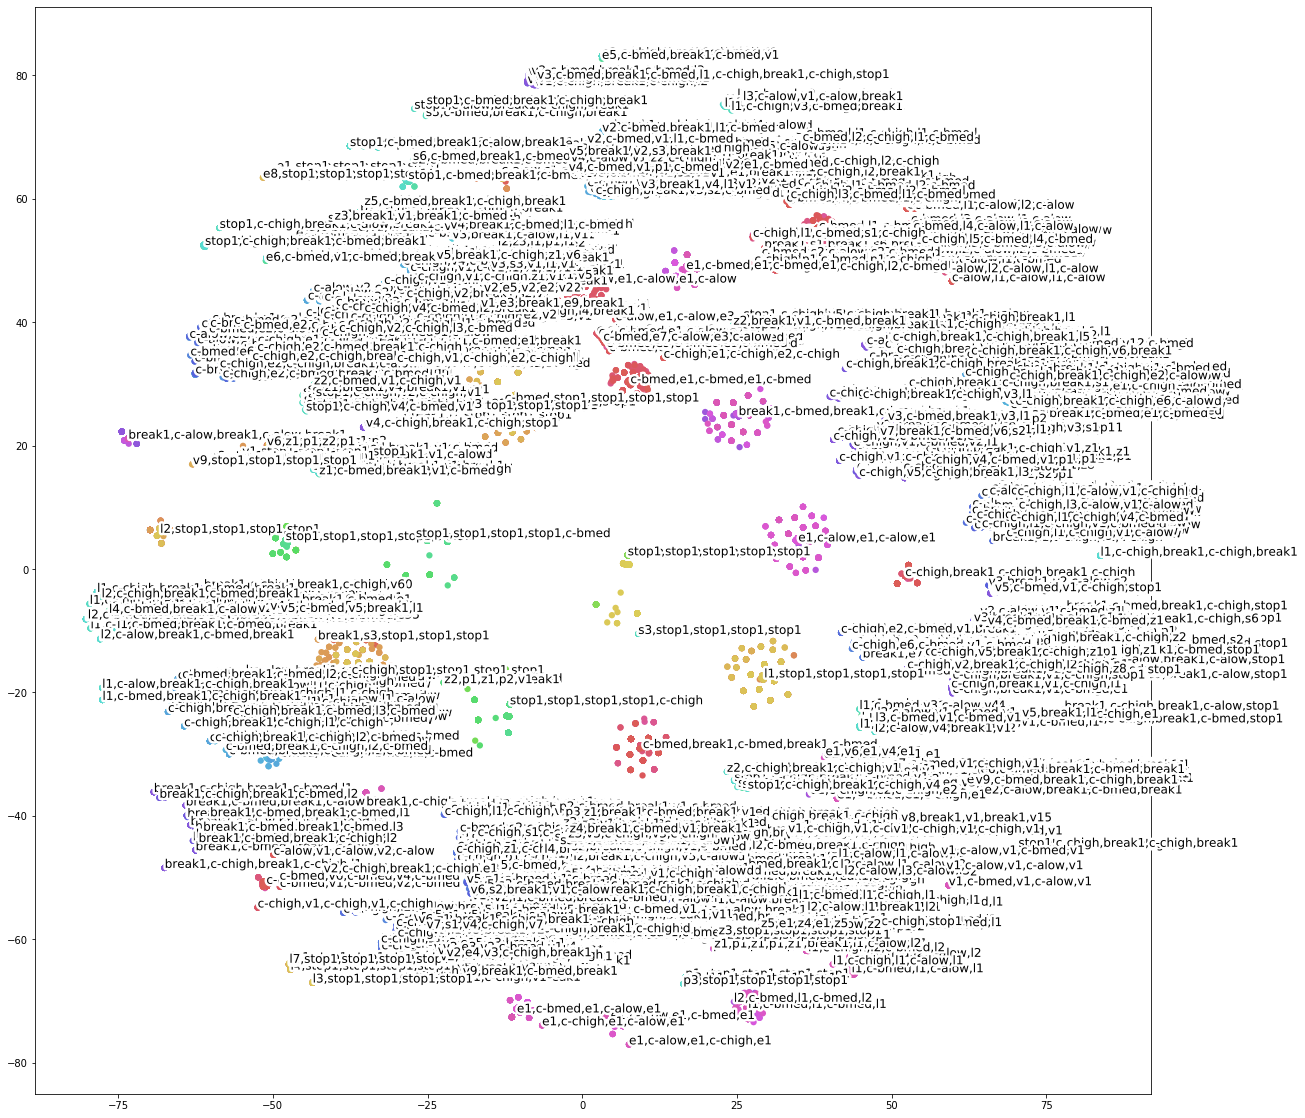

In [83]:
tsne_scatter(sax_tsne_o3, sax_mtf_o3)

In [66]:
mtf_o3 = get_exact_patterns1(sax_o3)

C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\utils.py:177: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\utils.py:177: RuntimeWarning: invalid value encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\distanceProfile.py:118: RuntimeWarning: invalid value encountered in sqrt
  distanceProfile = np.real(np.sqrt(mass(query,tsB).astype(complex)))
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\matrixProfile.py:249: RuntimeWarning: invalid value encountered in less
  idsToUpdate = distanceProfile < mp
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\utils.py:200: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean[index]*mean)/(m*std[index]*std))
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\utils.py:200: RuntimeWarning: 

['c-chigh', 'v1', 's1', 'e2', 'v5']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['e2', 'v5', 'e5', 'c-alow', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']



In [67]:
tsne_o3 = TSNE(random_state=22).fit_transform(pd.DataFrame(mtf_o3[1]))

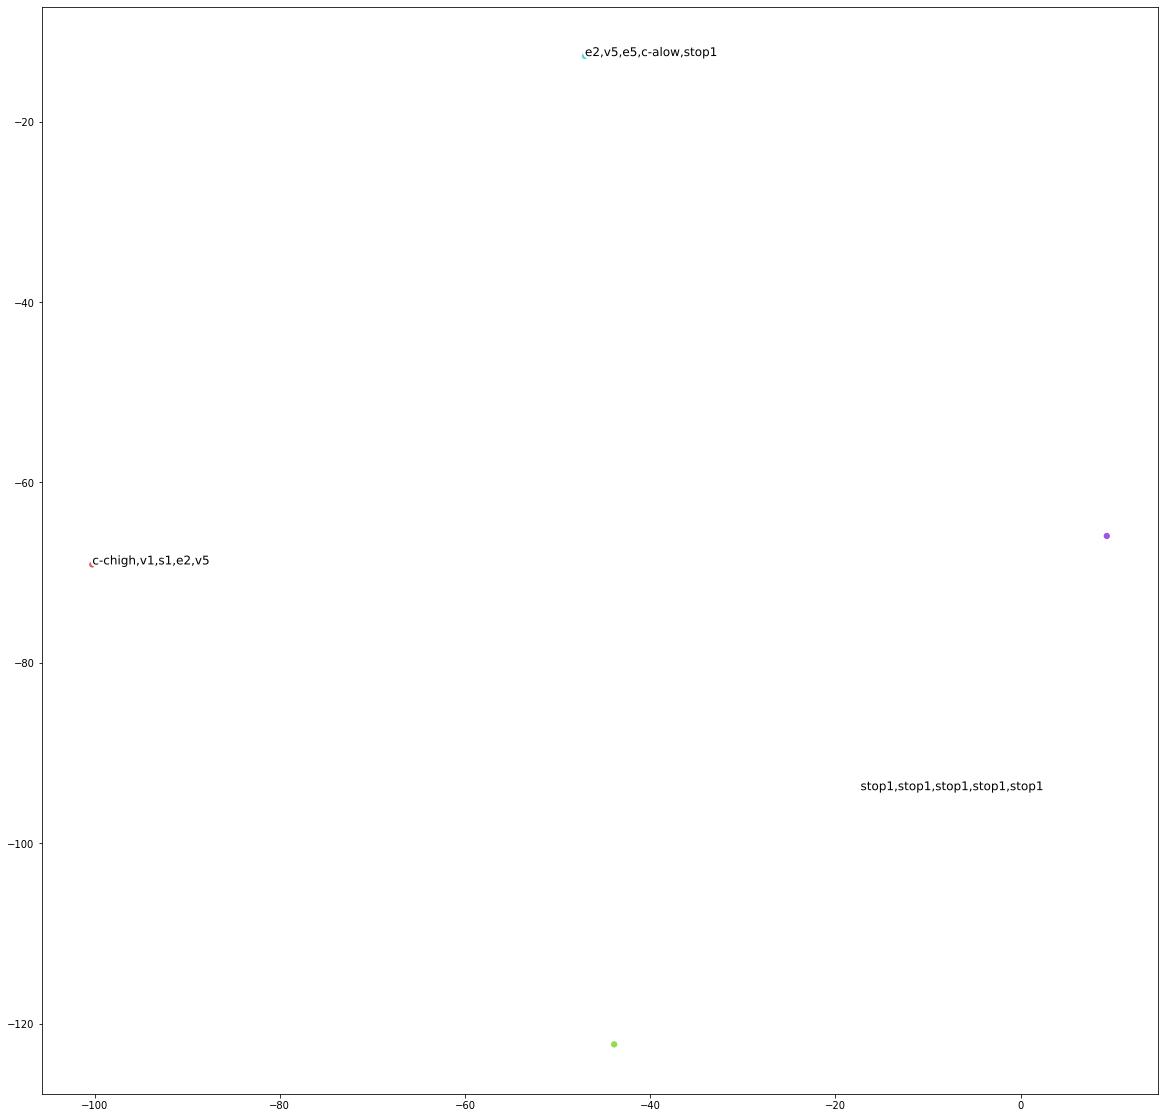

In [68]:
tsne_scatter(tsne_o3, mtf_o3)

In [69]:
sax_s2 = get_patterns_bins1(s2, bins2)

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mistr\Anaconda3\lib\site-packages\pandas\core\generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This

Start encoding....
Done encoding.
Get labels...
Labels done.
Start SAX transformation...
SAX transformation done.


In [70]:
most_common(sax_s2) # bcos cnt_lvl was set to 100.

Total Number of patterns: 0


In [84]:
sax_mtf_s2 = most_common1(sax_s2, 20)

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['c-chigh', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['e1', 'stop1', 'stop1', 'stop1', 'stop1']

['v4', 's2', 'stop1', 'stop1', 'stop1']

['c-bmed', 'l1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['c-alow', 'stop1', 'stop1', 'stop1', 'stop1']

['v2', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['break1', 'l1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['c-chigh', 'stop1', 'stop1', 'stop1', 'stop1']

['l1', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['e1', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1'

In [85]:
sax_tsne_s2 = TSNE(random_state=22).fit_transform(pd.DataFrame(sax_mtf_s2[1]))

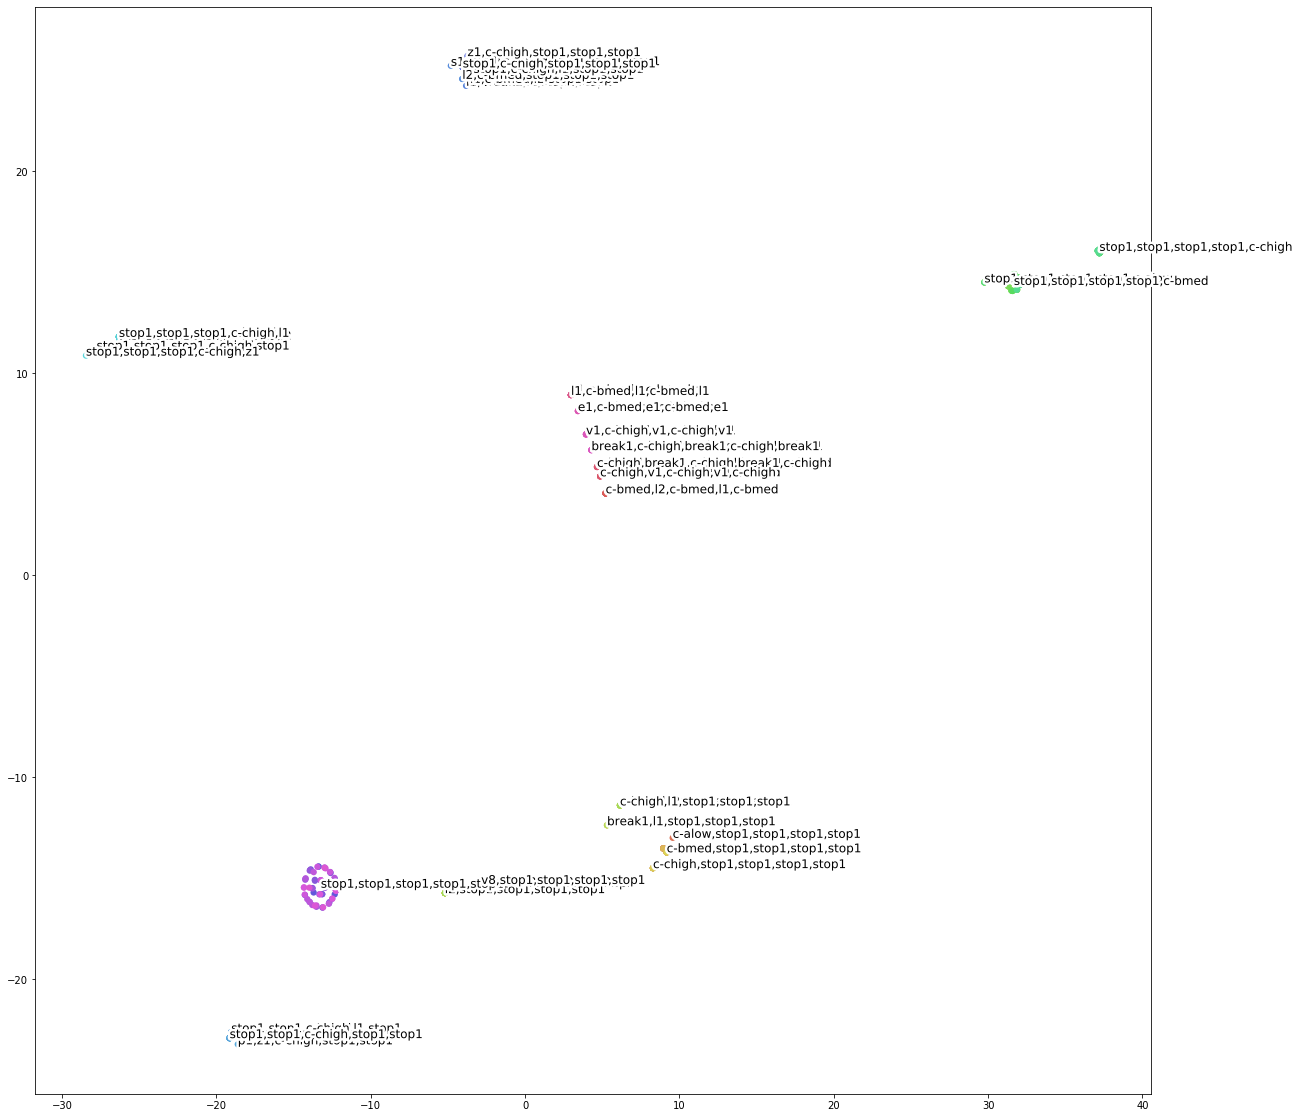

In [86]:
tsne_scatter(sax_tsne_s2, sax_mtf_s2)

In [87]:
mtf_s2 = get_exact_patterns1(sax_s2)

C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\utils.py:177: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\utils.py:200: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean[index]*mean)/(m*std[index]*std))
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\utils.py:200: RuntimeWarning: invalid value encountered in true_divide
  res = 2*m*(1-(dot-m*mean[index]*mean)/(m*std[index]*std))
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\distanceProfile.py:126: RuntimeWarning: invalid value encountered in sqrt
  distanceProfile = np.real(np.sqrt(res.astype(complex)))
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\matrixProfile.py:249: RuntimeWarning: invalid value encountered in less
  idsToUpdate = distanceProfile < mp


['stop1', 'stop1', 'stop1', 'c-bmed', 'stop1']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']

['c-chigh', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'stop1', 'stop1', 'stop1', 'stop1']

['c-bmed', 'e3', 'c-bmed', 's4', 'c-bmed']

['stop1', 'stop1', 'stop1', 'stop1', 'stop1']



C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\utils.py:177: RuntimeWarning: invalid value encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
C:\Users\mistr\Anaconda3\lib\site-packages\matrixprofile\distanceProfile.py:66: RuntimeWarning: invalid value encountered in sqrt
  distanceProfile = np.real(np.sqrt(mass(query,tsB).astype(complex)))


In [88]:
tsne_s2 = TSNE(random_state=22).fit_transform(pd.DataFrame(mtf_s2[1]))

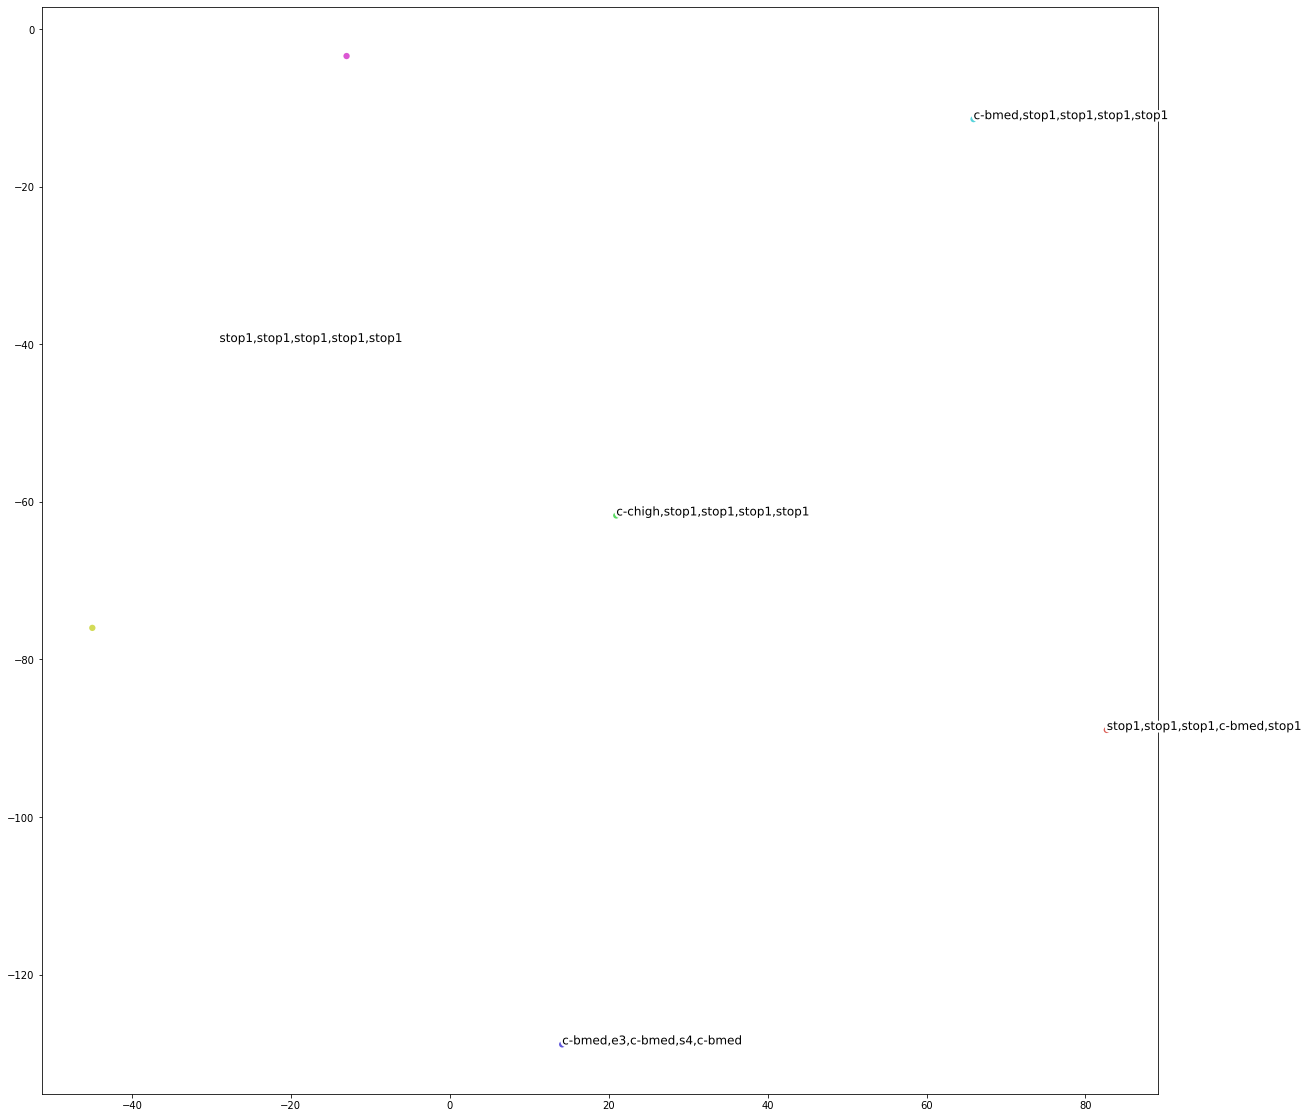

In [89]:
tsne_scatter(tsne_s2, mtf_s2)